# Step 1. Getting the SEED dataset

this notebook is training and testing EEG-Conformer's performance on BCIC42a datset, **the 1st subject only**.
- Trainset: A01T.gdf
- Testset: A01E.gdf

288 trials each file
22 channels, sampling rate = 250hz, sample_window=4seconds, start_offset=2seconds
4-class MI classification: left-hand, right-hand, feet, tongue.

## 1.1 load the matlab format files and take a look

In [1]:
import mne
from scipy import io
import os
import numpy as np

In [2]:
train_X_gdf = mne.io.read_raw_gdf('../Datasets/BCIC42a/A01T.gdf')
train_X_gdf.load_data()
test_X_gdf = mne.io.read_raw_gdf('../Datasets/BCIC42a/A01E.gdf')
test_X_gdf.load_data()

Extracting EDF parameters from /mnt/workspace/EEG-Conformer/Datasets/BCIC42a/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/home/pai/envs/fbc/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Extracting EDF parameters from /mnt/workspace/EEG-Conformer/Datasets/BCIC42a/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/home/pai/envs/fbc/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 25 x 687000 (2748.0 s), ~131.1 MB, data loaded>

In [3]:
train_y_mat = io.loadmat('../Datasets/BCIC42a/A01T.mat')
test_y_mat = io.loadmat('../Datasets/BCIC42a/A01E.mat')
train_y_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'classlabel'])

In [4]:
train_y_mat['classlabel'].shape, test_y_mat['classlabel'].shape

((288, 1), (288, 1))

In [5]:
gdf_event_labels_1 = mne.events_from_annotations(train_X_gdf)[1]
gdf_event_labels_2 = mne.events_from_annotations(test_X_gdf)[1]
gdf_event_labels_1, gdf_event_labels_2

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


({'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10},
 {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7})

note: event annotation '768' is the start of the trial at t=0 timepoint

In [6]:
train_gdf_events = mne.events_from_annotations(train_X_gdf)[0][:, [0, 2]].tolist()
test_gdf_events = mne.events_from_annotations(test_X_gdf)[0][:, [0, 2]].tolist()
train_gdf_events[:10], test_gdf_events[:10]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


([[0, 5],
  [0, 3],
  [29683, 5],
  [29683, 4],
  [49955, 5],
  [49955, 2],
  [91518, 5],
  [91868, 6],
  [92368, 10],
  [93871, 6]],
 [[0, 5],
  [0, 3],
  [34291, 5],
  [34291, 4],
  [68850, 5],
  [68850, 2],
  [105990, 5],
  [106340, 6],
  [106840, 7],
  [108343, 6]])

In [7]:
train_eeg = train_X_gdf.get_data()
test_eeg = test_X_gdf.get_data()

In [8]:
train_eeg.shape, test_eeg.shape

((25, 672528), (25, 687000))

In [9]:
chans_no = list(range(22))

In [10]:
train_eeg = train_eeg[chans_no, :]
test_eeg = test_eeg[chans_no, :]
train_eeg.shape, test_eeg.shape

((22, 672528), (22, 687000))

In [11]:
train_events = [event for event in train_gdf_events if event[1] == 6]
test_events = [event for event in test_gdf_events if event[1] == 6]
len(train_events), len(test_events)

(288, 288)

In [12]:
train_y = np.array([i[1] for i in train_events])
test_y = np.array([i[1] for i in test_events])
train_y.shape, test_y.shape

((288,), (288,))

In [13]:
epochInterval = np.array(range(0, 4 * 250)) + 2 * 250 # 2 is the offset
epochInterval

array([ 500,  501,  502,  503,  504,  505,  506,  507,  508,  509,  510,
        511,  512,  513,  514,  515,  516,  517,  518,  519,  520,  521,
        522,  523,  524,  525,  526,  527,  528,  529,  530,  531,  532,
        533,  534,  535,  536,  537,  538,  539,  540,  541,  542,  543,
        544,  545,  546,  547,  548,  549,  550,  551,  552,  553,  554,
        555,  556,  557,  558,  559,  560,  561,  562,  563,  564,  565,
        566,  567,  568,  569,  570,  571,  572,  573,  574,  575,  576,
        577,  578,  579,  580,  581,  582,  583,  584,  585,  586,  587,
        588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,
        610,  611,  612,  613,  614,  615,  616,  617,  618,  619,  620,
        621,  622,  623,  624,  625,  626,  627,  628,  629,  630,  631,
        632,  633,  634,  635,  636,  637,  638,  639,  640,  641,  642,
        643,  644,  645,  646,  647,  648,  649,  6

In [14]:
train_X = np.stack([train_eeg[:, epochInterval + event[0] ] for event in train_events], axis=2)
test_X = np.stack([test_eeg[:, epochInterval + event[0] ] for event in test_events], axis=2)
train_X.shape, test_X.shape

((22, 1000, 288), (22, 1000, 288))

In [15]:
train_X = train_X * 1e6 
test_X = test_X * 1e6

In [16]:
train_y = train_y_mat['classlabel'].squeeze()
test_y = test_y_mat['classlabel'].squeeze()
train_y = train_y - 1
test_y = test_y - 1
train_y.shape, test_y.shape

((288,), (288,))

In [17]:
train_X = train_X.transpose((2, 0, 1))
test_X = test_X.transpose((2, 0, 1))
train_X.shape, test_X.shape

((288, 22, 1000), (288, 22, 1000))

## 1.2 Create the torch dataset

### 1.2.2 Encode the labels

In [18]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch

/home/pai/envs/fbc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
batch_size = 288
# Segmentation and Reconstruction (S&R) data augmentation
def interaug(timg, label):
    # print("In interaug.")
    aug_data = []
    aug_label = []
    for cls4aug in range(4):
        # cls_idx = np.where(label == cls4aug + 1)
        cls_idx = np.where(label == cls4aug)
        tmp_data = timg[cls_idx]
        tmp_data = tmp_data.reshape(tmp_data.shape[0], -1, *tmp_data.shape[-2:])
        tmp_label = label[cls_idx]
        # print(timg.shape) # (288, 1, 22, 1000)
        # print(tmp_data.shape) # (72, 1, 22, 1000)
        # print(label.shape) # (288, 1)
        # print(tmp_label.shape) # (72,)

        tmp_aug_data = np.zeros((int(batch_size / 4), 1, 22, 1000))
        # print(f"tmp_aug_data.shape = {tmp_aug_data.shape}")
        # drf: get 8 slices of 8 random data from tmp_data, from the same time period idx
        for ri in range(int(batch_size / 4)):
            for rj in range(8):
                # print(f"ri, rj: {ri}, {rj}")
                rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                tmp_aug_data[ri, :, :, rj * 125:(rj + 1) * 125] = tmp_data[rand_idx[rj], :, :,
                                                                    rj * 125:(rj + 1) * 125]

        aug_data.append(tmp_aug_data)
        aug_label.append(tmp_label[:int(batch_size / 4)])
    aug_data = np.concatenate(aug_data)
    aug_label = np.concatenate(aug_label)
    aug_shuffle = np.random.permutation(len(aug_data))
    aug_data = aug_data[aug_shuffle, :, :]
    aug_label = aug_label[aug_shuffle]

    aug_data = torch.from_numpy(aug_data).cuda()
    aug_data = aug_data.float()
    # aug_label = torch.from_numpy(aug_label-1).cuda()
    aug_label = torch.from_numpy(aug_label).cuda()
    aug_label = aug_label.long()
    return aug_data, aug_label

In [20]:
aug_X, aug_y = interaug(train_X, train_y)

In [21]:
aug_X.shape, aug_y.shape

(torch.Size([288, 1, 22, 1000]), torch.Size([288]))

In [22]:
aug_X.squeeze_(dim=1)
aug_X.shape

torch.Size([288, 22, 1000])

In [23]:
train_X.shape, train_y.shape

((288, 22, 1000), (288,))

In [24]:
train_X_aug = np.concatenate([train_X, aug_X.cpu().numpy()])
train_X_aug.shape

(576, 22, 1000)

In [25]:
train_y_aug = np.concatenate([train_y, aug_y.cpu().numpy()])
train_y_aug.shape

(576,)

In [26]:
train_X = train_X_aug
train_y = train_y_aug

In [27]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
train_y = pd.get_dummies(train_y)
train_y

,0,1,2,3
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
571,0,1,0,0
572,1,0,0,0
573,0,0,1,0
574,1,0,0,0


In [28]:
test_y = le.fit_transform(test_y)
test_y = pd.get_dummies(test_y)
test_y

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
283,0,0,1,0
284,0,0,0,1
285,0,0,1,0
286,1,0,0,0


one-hot encoding

In [29]:
train_X.shape, train_y.shape

((576, 22, 1000), (576, 4))

# Step 2. Create EEG-conformer model

In [30]:
import torch
# from braindecode.models import EEGConformer
from braindecode.util import set_random_seeds

from eegconformer import EEGConformer

In [31]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"
device

True


'cuda'

In [32]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [33]:
seed = 20240216
set_random_seeds(seed=seed, cuda=cuda)

model = EEGConformer(
    n_outputs=4,
    n_chans=22,
    n_times=1000, # input_winodw_samples
    sfreq=250,
    n_filters_time=40, 
    filter_time_length=25,
    pool_time_length=75,
    pool_time_stride=15,
    drop_prob=0.7,
    att_depth=3,
    att_heads=10,
    att_drop_prob=0.7,
    final_fc_length='auto', # could be 'auto' or int
    return_features=False, # returns the features before the last classification layer if True
    chs_info=None,
    input_window_seconds=None,
    add_log_softmax=True,
)

print(model)

/mnt/workspace/EEG-Conformer/Codes/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 22, 1000]             [1, 4]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 22, 1000]          [1, 61, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 22, 1000]          [1, 40, 1, 61]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 22, 1000]          [1, 40, 22, 976]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 22, 976]          [1, 40, 1, 976]           35,240                    [22, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 976]           [1, 40, 1, 976]           80             

In [34]:
if cuda:
    model.cuda()

# Step 3. Training the model

## 3.1 prepare the train set / test set

In [35]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline

In [36]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((576, 22, 1000), (288, 22, 1000), (576, 4), (288, 4))

In [37]:
# train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, train_size=0.7, random_state=777)

## 3.2 Training

In [38]:
train_X.shape, train_y.shape

((576, 22, 1000), (576, 4))

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))
batch_size=72

x_train_tensor = torch.from_numpy(train_X).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(train_y.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_test_tensor = torch.from_numpy(test_X).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(test_y.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [41]:
def train(model, x_train, y_train, x_test, y_test, save_path='../Models/BCIC42a-sub1/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [42]:
best_model = train(model, train_X, test_X, train_y, test_y, n_epochs=1000)

the model will be trained on:  cuda


100%|██████████| 8/8 [00:00<00:00, 21.02it/s]


best_model found, best acc:  0.22569444444444445
Epoch 1/1000 - Train Loss: 1.4098 - Train Accuracy: 0.2622 - Test Loss: 1.3802 - Test Accuracy: 0.2257


100%|██████████| 8/8 [00:00<00:00, 45.70it/s]


best_model found, best acc:  0.28125
Epoch 2/1000 - Train Loss: 1.4002 - Train Accuracy: 0.2795 - Test Loss: 1.3695 - Test Accuracy: 0.2812


100%|██████████| 8/8 [00:00<00:00, 45.29it/s]


best_model found, best acc:  0.2881944444444444
Epoch 3/1000 - Train Loss: 1.3827 - Train Accuracy: 0.2934 - Test Loss: 1.3638 - Test Accuracy: 0.2882


100%|██████████| 8/8 [00:00<00:00, 44.81it/s]


best_model found, best acc:  0.34375
Epoch 4/1000 - Train Loss: 1.3670 - Train Accuracy: 0.2969 - Test Loss: 1.3467 - Test Accuracy: 0.3438


100%|██████████| 8/8 [00:00<00:00, 42.88it/s]


best_model found, best acc:  0.3541666666666667
Epoch 5/1000 - Train Loss: 1.3522 - Train Accuracy: 0.3264 - Test Loss: 1.3335 - Test Accuracy: 0.3542


100%|██████████| 8/8 [00:00<00:00, 42.90it/s]


Epoch 6/1000 - Train Loss: 1.3498 - Train Accuracy: 0.3628 - Test Loss: 1.3212 - Test Accuracy: 0.3472


100%|██████████| 8/8 [00:00<00:00, 45.11it/s]


Epoch 7/1000 - Train Loss: 1.2920 - Train Accuracy: 0.3993 - Test Loss: 1.3132 - Test Accuracy: 0.3438


100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 8/1000 - Train Loss: 1.2909 - Train Accuracy: 0.3802 - Test Loss: 1.3154 - Test Accuracy: 0.3438


100%|██████████| 8/8 [00:00<00:00, 48.70it/s]


Epoch 9/1000 - Train Loss: 1.2450 - Train Accuracy: 0.4271 - Test Loss: 1.3200 - Test Accuracy: 0.3507


100%|██████████| 8/8 [00:00<00:00, 48.09it/s]


best_model found, best acc:  0.3680555555555556
Epoch 10/1000 - Train Loss: 1.2192 - Train Accuracy: 0.4340 - Test Loss: 1.3167 - Test Accuracy: 0.3681


100%|██████████| 8/8 [00:00<00:00, 49.81it/s]


best_model found, best acc:  0.3958333333333333
Epoch 11/1000 - Train Loss: 1.1888 - Train Accuracy: 0.5122 - Test Loss: 1.2942 - Test Accuracy: 0.3958


100%|██████████| 8/8 [00:00<00:00, 47.30it/s]


Epoch 12/1000 - Train Loss: 1.1576 - Train Accuracy: 0.4931 - Test Loss: 1.2781 - Test Accuracy: 0.3958


100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


best_model found, best acc:  0.4340277777777778
Epoch 13/1000 - Train Loss: 1.1207 - Train Accuracy: 0.5208 - Test Loss: 1.2382 - Test Accuracy: 0.4340


100%|██████████| 8/8 [00:00<00:00, 48.87it/s]


best_model found, best acc:  0.4548611111111111
Epoch 14/1000 - Train Loss: 1.0729 - Train Accuracy: 0.5608 - Test Loss: 1.1978 - Test Accuracy: 0.4549


100%|██████████| 8/8 [00:00<00:00, 49.80it/s]


best_model found, best acc:  0.4722222222222222
Epoch 15/1000 - Train Loss: 1.0281 - Train Accuracy: 0.5677 - Test Loss: 1.1536 - Test Accuracy: 0.4722


100%|██████████| 8/8 [00:00<00:00, 49.59it/s]


best_model found, best acc:  0.5034722222222222
Epoch 16/1000 - Train Loss: 0.9941 - Train Accuracy: 0.5677 - Test Loss: 1.1204 - Test Accuracy: 0.5035


100%|██████████| 8/8 [00:00<00:00, 50.36it/s]


best_model found, best acc:  0.5347222222222222
Epoch 17/1000 - Train Loss: 0.9457 - Train Accuracy: 0.5938 - Test Loss: 1.0639 - Test Accuracy: 0.5347


100%|██████████| 8/8 [00:00<00:00, 49.30it/s]


best_model found, best acc:  0.5590277777777778
Epoch 18/1000 - Train Loss: 0.9054 - Train Accuracy: 0.6319 - Test Loss: 1.0336 - Test Accuracy: 0.5590


100%|██████████| 8/8 [00:00<00:00, 47.52it/s]


best_model found, best acc:  0.5694444444444444
Epoch 19/1000 - Train Loss: 0.8243 - Train Accuracy: 0.6458 - Test Loss: 1.1297 - Test Accuracy: 0.5694


100%|██████████| 8/8 [00:00<00:00, 48.84it/s]


Epoch 20/1000 - Train Loss: 0.7816 - Train Accuracy: 0.6823 - Test Loss: 1.1776 - Test Accuracy: 0.5694


100%|██████████| 8/8 [00:00<00:00, 50.09it/s]


Epoch 21/1000 - Train Loss: 0.7380 - Train Accuracy: 0.6806 - Test Loss: 1.1832 - Test Accuracy: 0.5694


100%|██████████| 8/8 [00:00<00:00, 49.73it/s]


Epoch 22/1000 - Train Loss: 0.7143 - Train Accuracy: 0.7083 - Test Loss: 1.3931 - Test Accuracy: 0.5382


100%|██████████| 8/8 [00:00<00:00, 50.60it/s]


best_model found, best acc:  0.5902777777777778
Epoch 23/1000 - Train Loss: 0.7231 - Train Accuracy: 0.6892 - Test Loss: 1.2287 - Test Accuracy: 0.5903


100%|██████████| 8/8 [00:00<00:00, 48.56it/s]


Epoch 24/1000 - Train Loss: 0.7023 - Train Accuracy: 0.6858 - Test Loss: 1.3526 - Test Accuracy: 0.5868


100%|██████████| 8/8 [00:00<00:00, 49.93it/s]


Epoch 25/1000 - Train Loss: 0.6907 - Train Accuracy: 0.7135 - Test Loss: 1.4393 - Test Accuracy: 0.5660


100%|██████████| 8/8 [00:00<00:00, 48.42it/s]


best_model found, best acc:  0.5972222222222222
Epoch 26/1000 - Train Loss: 0.6414 - Train Accuracy: 0.7344 - Test Loss: 1.2922 - Test Accuracy: 0.5972


100%|██████████| 8/8 [00:00<00:00, 49.44it/s]


Epoch 27/1000 - Train Loss: 0.6588 - Train Accuracy: 0.6979 - Test Loss: 1.4048 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 28/1000 - Train Loss: 0.6237 - Train Accuracy: 0.7413 - Test Loss: 1.4609 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 47.52it/s]


Epoch 29/1000 - Train Loss: 0.6196 - Train Accuracy: 0.7378 - Test Loss: 1.3613 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 49.26it/s]


Epoch 30/1000 - Train Loss: 0.6167 - Train Accuracy: 0.7465 - Test Loss: 1.5437 - Test Accuracy: 0.5903


100%|██████████| 8/8 [00:00<00:00, 48.81it/s]


Epoch 31/1000 - Train Loss: 0.6376 - Train Accuracy: 0.7344 - Test Loss: 1.4488 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 48.77it/s]


Epoch 32/1000 - Train Loss: 0.5703 - Train Accuracy: 0.7517 - Test Loss: 1.4479 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 48.52it/s]


best_model found, best acc:  0.6215277777777778
Epoch 33/1000 - Train Loss: 0.5794 - Train Accuracy: 0.7483 - Test Loss: 1.2772 - Test Accuracy: 0.6215


100%|██████████| 8/8 [00:00<00:00, 51.02it/s]


Epoch 34/1000 - Train Loss: 0.5395 - Train Accuracy: 0.7639 - Test Loss: 1.5690 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


best_model found, best acc:  0.6388888888888888
Epoch 35/1000 - Train Loss: 0.5942 - Train Accuracy: 0.7465 - Test Loss: 1.3345 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 36/1000 - Train Loss: 0.5213 - Train Accuracy: 0.7778 - Test Loss: 1.5198 - Test Accuracy: 0.6007


100%|██████████| 8/8 [00:00<00:00, 49.44it/s]


Epoch 37/1000 - Train Loss: 0.5853 - Train Accuracy: 0.7604 - Test Loss: 1.4064 - Test Accuracy: 0.6076


100%|██████████| 8/8 [00:00<00:00, 48.22it/s]


Epoch 38/1000 - Train Loss: 0.5165 - Train Accuracy: 0.7778 - Test Loss: 1.3603 - Test Accuracy: 0.6319


100%|██████████| 8/8 [00:00<00:00, 49.10it/s]


Epoch 39/1000 - Train Loss: 0.5609 - Train Accuracy: 0.7552 - Test Loss: 1.3791 - Test Accuracy: 0.5868


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 40/1000 - Train Loss: 0.5502 - Train Accuracy: 0.7587 - Test Loss: 1.4013 - Test Accuracy: 0.5729


100%|██████████| 8/8 [00:00<00:00, 50.78it/s]


Epoch 41/1000 - Train Loss: 0.5266 - Train Accuracy: 0.7830 - Test Loss: 1.6564 - Test Accuracy: 0.5521


100%|██████████| 8/8 [00:00<00:00, 51.04it/s]


Epoch 42/1000 - Train Loss: 0.4805 - Train Accuracy: 0.7986 - Test Loss: 1.3246 - Test Accuracy: 0.6285


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Epoch 43/1000 - Train Loss: 0.4627 - Train Accuracy: 0.8281 - Test Loss: 1.7624 - Test Accuracy: 0.5833


100%|██████████| 8/8 [00:00<00:00, 42.25it/s]


best_model found, best acc:  0.6527777777777778
Epoch 44/1000 - Train Loss: 0.4371 - Train Accuracy: 0.8281 - Test Loss: 1.2806 - Test Accuracy: 0.6528


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


Epoch 45/1000 - Train Loss: 0.4310 - Train Accuracy: 0.8403 - Test Loss: 1.4969 - Test Accuracy: 0.6042


100%|██████████| 8/8 [00:00<00:00, 49.12it/s]


Epoch 46/1000 - Train Loss: 0.4276 - Train Accuracy: 0.8299 - Test Loss: 1.5715 - Test Accuracy: 0.6111


100%|██████████| 8/8 [00:00<00:00, 48.49it/s]


Epoch 47/1000 - Train Loss: 0.4461 - Train Accuracy: 0.8142 - Test Loss: 1.6003 - Test Accuracy: 0.5764


100%|██████████| 8/8 [00:00<00:00, 49.85it/s]


Epoch 48/1000 - Train Loss: 0.3961 - Train Accuracy: 0.8507 - Test Loss: 1.5827 - Test Accuracy: 0.6111


100%|██████████| 8/8 [00:00<00:00, 51.01it/s]


Epoch 49/1000 - Train Loss: 0.4031 - Train Accuracy: 0.8438 - Test Loss: 1.3425 - Test Accuracy: 0.6181


100%|██████████| 8/8 [00:00<00:00, 49.52it/s]


Epoch 50/1000 - Train Loss: 0.4451 - Train Accuracy: 0.8264 - Test Loss: 1.6747 - Test Accuracy: 0.6181


100%|██████████| 8/8 [00:00<00:00, 47.19it/s]


best_model found, best acc:  0.6631944444444444
Epoch 51/1000 - Train Loss: 0.4224 - Train Accuracy: 0.8385 - Test Loss: 1.3331 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 49.80it/s]


Epoch 52/1000 - Train Loss: 0.4068 - Train Accuracy: 0.8299 - Test Loss: 1.6197 - Test Accuracy: 0.6146


100%|██████████| 8/8 [00:00<00:00, 48.02it/s]


Epoch 53/1000 - Train Loss: 0.4289 - Train Accuracy: 0.8090 - Test Loss: 1.4286 - Test Accuracy: 0.6042


100%|██████████| 8/8 [00:00<00:00, 48.69it/s]


Epoch 54/1000 - Train Loss: 0.4106 - Train Accuracy: 0.8455 - Test Loss: 1.4176 - Test Accuracy: 0.6215


100%|██████████| 8/8 [00:00<00:00, 45.21it/s]


Epoch 55/1000 - Train Loss: 0.3969 - Train Accuracy: 0.8385 - Test Loss: 1.2519 - Test Accuracy: 0.6354


100%|██████████| 8/8 [00:00<00:00, 42.93it/s]


Epoch 56/1000 - Train Loss: 0.3445 - Train Accuracy: 0.8733 - Test Loss: 1.3133 - Test Accuracy: 0.6076


100%|██████████| 8/8 [00:00<00:00, 40.98it/s]


Epoch 57/1000 - Train Loss: 0.3587 - Train Accuracy: 0.8733 - Test Loss: 1.5477 - Test Accuracy: 0.6181


100%|██████████| 8/8 [00:00<00:00, 43.29it/s]


Epoch 58/1000 - Train Loss: 0.3743 - Train Accuracy: 0.8646 - Test Loss: 1.6547 - Test Accuracy: 0.6076


100%|██████████| 8/8 [00:00<00:00, 45.77it/s]


Epoch 59/1000 - Train Loss: 0.3828 - Train Accuracy: 0.8524 - Test Loss: 1.5914 - Test Accuracy: 0.6146


100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 60/1000 - Train Loss: 0.3878 - Train Accuracy: 0.8420 - Test Loss: 1.4000 - Test Accuracy: 0.6146


100%|██████████| 8/8 [00:00<00:00, 47.49it/s]


Epoch 61/1000 - Train Loss: 0.3523 - Train Accuracy: 0.8663 - Test Loss: 1.5736 - Test Accuracy: 0.6319


100%|██████████| 8/8 [00:00<00:00, 48.39it/s]


Epoch 62/1000 - Train Loss: 0.3520 - Train Accuracy: 0.8681 - Test Loss: 1.4633 - Test Accuracy: 0.6076


100%|██████████| 8/8 [00:00<00:00, 47.38it/s]


Epoch 63/1000 - Train Loss: 0.3270 - Train Accuracy: 0.8767 - Test Loss: 1.5778 - Test Accuracy: 0.6007


100%|██████████| 8/8 [00:00<00:00, 48.44it/s]


Epoch 64/1000 - Train Loss: 0.3456 - Train Accuracy: 0.8715 - Test Loss: 1.6087 - Test Accuracy: 0.6181


100%|██████████| 8/8 [00:00<00:00, 49.91it/s]


Epoch 65/1000 - Train Loss: 0.3528 - Train Accuracy: 0.8524 - Test Loss: 1.2890 - Test Accuracy: 0.6042


100%|██████████| 8/8 [00:00<00:00, 49.27it/s]


Epoch 66/1000 - Train Loss: 0.3232 - Train Accuracy: 0.8872 - Test Loss: 1.4537 - Test Accuracy: 0.6215


100%|██████████| 8/8 [00:00<00:00, 50.25it/s]


Epoch 67/1000 - Train Loss: 0.3254 - Train Accuracy: 0.8802 - Test Loss: 1.2493 - Test Accuracy: 0.6250


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


best_model found, best acc:  0.6736111111111112
Epoch 68/1000 - Train Loss: 0.3513 - Train Accuracy: 0.8611 - Test Loss: 1.2176 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 47.68it/s]


Epoch 69/1000 - Train Loss: 0.3500 - Train Accuracy: 0.8663 - Test Loss: 1.4748 - Test Accuracy: 0.6042


100%|██████████| 8/8 [00:00<00:00, 48.73it/s]


Epoch 70/1000 - Train Loss: 0.3228 - Train Accuracy: 0.8767 - Test Loss: 1.5951 - Test Accuracy: 0.6007


100%|██████████| 8/8 [00:00<00:00, 50.10it/s]


Epoch 71/1000 - Train Loss: 0.2976 - Train Accuracy: 0.8854 - Test Loss: 1.3818 - Test Accuracy: 0.6250


100%|██████████| 8/8 [00:00<00:00, 50.95it/s]


Epoch 72/1000 - Train Loss: 0.2834 - Train Accuracy: 0.8976 - Test Loss: 1.3367 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 49.04it/s]


Epoch 73/1000 - Train Loss: 0.2624 - Train Accuracy: 0.9132 - Test Loss: 1.7578 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 49.65it/s]


Epoch 74/1000 - Train Loss: 0.2972 - Train Accuracy: 0.8854 - Test Loss: 1.3808 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Epoch 75/1000 - Train Loss: 0.3237 - Train Accuracy: 0.8837 - Test Loss: 1.6790 - Test Accuracy: 0.5868


100%|██████████| 8/8 [00:00<00:00, 43.11it/s]


Epoch 76/1000 - Train Loss: 0.3022 - Train Accuracy: 0.8733 - Test Loss: 1.5262 - Test Accuracy: 0.6042


100%|██████████| 8/8 [00:00<00:00, 48.49it/s]


Epoch 77/1000 - Train Loss: 0.2665 - Train Accuracy: 0.8993 - Test Loss: 1.6113 - Test Accuracy: 0.5938


100%|██████████| 8/8 [00:00<00:00, 49.66it/s]


Epoch 78/1000 - Train Loss: 0.2868 - Train Accuracy: 0.8906 - Test Loss: 1.4103 - Test Accuracy: 0.6215


100%|██████████| 8/8 [00:00<00:00, 49.59it/s]


Epoch 79/1000 - Train Loss: 0.3082 - Train Accuracy: 0.8802 - Test Loss: 1.5230 - Test Accuracy: 0.6250


100%|██████████| 8/8 [00:00<00:00, 49.25it/s]


Epoch 80/1000 - Train Loss: 0.3161 - Train Accuracy: 0.8837 - Test Loss: 1.5038 - Test Accuracy: 0.6354


100%|██████████| 8/8 [00:00<00:00, 48.85it/s]


Epoch 81/1000 - Train Loss: 0.2691 - Train Accuracy: 0.8993 - Test Loss: 1.6253 - Test Accuracy: 0.6319


100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


Epoch 82/1000 - Train Loss: 0.2843 - Train Accuracy: 0.8802 - Test Loss: 1.4721 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 48.47it/s]


Epoch 83/1000 - Train Loss: 0.2351 - Train Accuracy: 0.9010 - Test Loss: 1.4398 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 48.70it/s]


Epoch 84/1000 - Train Loss: 0.2755 - Train Accuracy: 0.8993 - Test Loss: 1.4106 - Test Accuracy: 0.6424


100%|██████████| 8/8 [00:00<00:00, 48.91it/s]


Epoch 85/1000 - Train Loss: 0.2729 - Train Accuracy: 0.8958 - Test Loss: 1.2711 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 86/1000 - Train Loss: 0.2652 - Train Accuracy: 0.8941 - Test Loss: 1.5275 - Test Accuracy: 0.6285


100%|██████████| 8/8 [00:00<00:00, 49.82it/s]


Epoch 87/1000 - Train Loss: 0.2500 - Train Accuracy: 0.9045 - Test Loss: 1.3834 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 47.42it/s]


Epoch 88/1000 - Train Loss: 0.2337 - Train Accuracy: 0.9028 - Test Loss: 1.4594 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 46.51it/s]


Epoch 89/1000 - Train Loss: 0.2300 - Train Accuracy: 0.9097 - Test Loss: 1.5249 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 90/1000 - Train Loss: 0.2056 - Train Accuracy: 0.9340 - Test Loss: 1.3848 - Test Accuracy: 0.6597


100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


Epoch 91/1000 - Train Loss: 0.2545 - Train Accuracy: 0.9028 - Test Loss: 1.4216 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 48.24it/s]


Epoch 92/1000 - Train Loss: 0.2159 - Train Accuracy: 0.9219 - Test Loss: 1.5836 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 47.41it/s]


Epoch 93/1000 - Train Loss: 0.2417 - Train Accuracy: 0.9010 - Test Loss: 1.3628 - Test Accuracy: 0.6458


100%|██████████| 8/8 [00:00<00:00, 47.37it/s]


Epoch 94/1000 - Train Loss: 0.2306 - Train Accuracy: 0.9236 - Test Loss: 1.4328 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 42.04it/s]


Epoch 95/1000 - Train Loss: 0.2128 - Train Accuracy: 0.9236 - Test Loss: 1.5817 - Test Accuracy: 0.6389


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


best_model found, best acc:  0.6770833333333334
Epoch 96/1000 - Train Loss: 0.2180 - Train Accuracy: 0.9201 - Test Loss: 1.3068 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 50.14it/s]


Epoch 97/1000 - Train Loss: 0.2485 - Train Accuracy: 0.9115 - Test Loss: 1.8828 - Test Accuracy: 0.6146


100%|██████████| 8/8 [00:00<00:00, 48.39it/s]


Epoch 98/1000 - Train Loss: 0.1805 - Train Accuracy: 0.9323 - Test Loss: 1.4691 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 50.54it/s]


Epoch 99/1000 - Train Loss: 0.2366 - Train Accuracy: 0.9062 - Test Loss: 1.3561 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 49.76it/s]


Epoch 100/1000 - Train Loss: 0.2026 - Train Accuracy: 0.9340 - Test Loss: 1.6516 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 47.98it/s]


Epoch 101/1000 - Train Loss: 0.2047 - Train Accuracy: 0.9149 - Test Loss: 1.7402 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 47.62it/s]


Epoch 102/1000 - Train Loss: 0.2109 - Train Accuracy: 0.9271 - Test Loss: 1.4016 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 49.75it/s]


Epoch 103/1000 - Train Loss: 0.1999 - Train Accuracy: 0.9288 - Test Loss: 1.6827 - Test Accuracy: 0.6354


100%|██████████| 8/8 [00:00<00:00, 50.74it/s]


best_model found, best acc:  0.6875
Epoch 104/1000 - Train Loss: 0.2198 - Train Accuracy: 0.9115 - Test Loss: 1.2073 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 48.36it/s]


Epoch 105/1000 - Train Loss: 0.2357 - Train Accuracy: 0.9115 - Test Loss: 1.6824 - Test Accuracy: 0.6181


100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


Epoch 106/1000 - Train Loss: 0.2061 - Train Accuracy: 0.9149 - Test Loss: 1.3108 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.28it/s]


Epoch 107/1000 - Train Loss: 0.2006 - Train Accuracy: 0.9097 - Test Loss: 1.3507 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 47.61it/s]


Epoch 108/1000 - Train Loss: 0.1824 - Train Accuracy: 0.9392 - Test Loss: 1.6096 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 46.56it/s]


Epoch 109/1000 - Train Loss: 0.1782 - Train Accuracy: 0.9236 - Test Loss: 1.4748 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 48.59it/s]


Epoch 110/1000 - Train Loss: 0.2212 - Train Accuracy: 0.9201 - Test Loss: 1.9024 - Test Accuracy: 0.6285


100%|██████████| 8/8 [00:00<00:00, 48.95it/s]


Epoch 111/1000 - Train Loss: 0.1573 - Train Accuracy: 0.9444 - Test Loss: 1.6475 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 47.80it/s]


Epoch 112/1000 - Train Loss: 0.1895 - Train Accuracy: 0.9219 - Test Loss: 1.6008 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 42.59it/s]


Epoch 113/1000 - Train Loss: 0.1996 - Train Accuracy: 0.9184 - Test Loss: 1.4578 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 40.59it/s]


Epoch 114/1000 - Train Loss: 0.1651 - Train Accuracy: 0.9392 - Test Loss: 1.5998 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 46.88it/s]


Epoch 115/1000 - Train Loss: 0.2219 - Train Accuracy: 0.9184 - Test Loss: 1.7230 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 48.92it/s]


best_model found, best acc:  0.6909722222222222
Epoch 116/1000 - Train Loss: 0.1982 - Train Accuracy: 0.9236 - Test Loss: 1.4905 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 50.44it/s]


Epoch 117/1000 - Train Loss: 0.1874 - Train Accuracy: 0.9358 - Test Loss: 1.6579 - Test Accuracy: 0.6424


100%|██████████| 8/8 [00:00<00:00, 50.37it/s]


Epoch 118/1000 - Train Loss: 0.1703 - Train Accuracy: 0.9392 - Test Loss: 1.6890 - Test Accuracy: 0.6354


100%|██████████| 8/8 [00:00<00:00, 48.21it/s]


Epoch 119/1000 - Train Loss: 0.2067 - Train Accuracy: 0.9132 - Test Loss: 1.5997 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 41.25it/s]


Epoch 120/1000 - Train Loss: 0.1661 - Train Accuracy: 0.9253 - Test Loss: 1.5809 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 47.03it/s]


Epoch 121/1000 - Train Loss: 0.1330 - Train Accuracy: 0.9635 - Test Loss: 1.4108 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 122/1000 - Train Loss: 0.1783 - Train Accuracy: 0.9375 - Test Loss: 1.4579 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 49.57it/s]


Epoch 123/1000 - Train Loss: 0.1593 - Train Accuracy: 0.9427 - Test Loss: 1.7439 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 49.30it/s]


Epoch 124/1000 - Train Loss: 0.1702 - Train Accuracy: 0.9497 - Test Loss: 1.6202 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 49.75it/s]


Epoch 125/1000 - Train Loss: 0.1550 - Train Accuracy: 0.9410 - Test Loss: 1.5375 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.00it/s]


Epoch 126/1000 - Train Loss: 0.1755 - Train Accuracy: 0.9375 - Test Loss: 1.4137 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 47.19it/s]


Epoch 127/1000 - Train Loss: 0.1671 - Train Accuracy: 0.9306 - Test Loss: 1.8712 - Test Accuracy: 0.6319


100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch 128/1000 - Train Loss: 0.1460 - Train Accuracy: 0.9444 - Test Loss: 1.5830 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 48.65it/s]


Epoch 129/1000 - Train Loss: 0.1711 - Train Accuracy: 0.9306 - Test Loss: 1.5418 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 49.95it/s]


best_model found, best acc:  0.6944444444444444
Epoch 130/1000 - Train Loss: 0.1527 - Train Accuracy: 0.9427 - Test Loss: 1.3770 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 48.86it/s]


best_model found, best acc:  0.6979166666666666
Epoch 131/1000 - Train Loss: 0.1311 - Train Accuracy: 0.9531 - Test Loss: 1.3343 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 47.55it/s]


Epoch 132/1000 - Train Loss: 0.1292 - Train Accuracy: 0.9549 - Test Loss: 1.8652 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 48.51it/s]


Epoch 133/1000 - Train Loss: 0.1570 - Train Accuracy: 0.9392 - Test Loss: 1.5025 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 134/1000 - Train Loss: 0.1452 - Train Accuracy: 0.9479 - Test Loss: 1.5950 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 50.68it/s]


Epoch 135/1000 - Train Loss: 0.1656 - Train Accuracy: 0.9514 - Test Loss: 1.5790 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 50.79it/s]


Epoch 136/1000 - Train Loss: 0.1513 - Train Accuracy: 0.9410 - Test Loss: 1.5423 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 51.16it/s]


Epoch 137/1000 - Train Loss: 0.1446 - Train Accuracy: 0.9410 - Test Loss: 1.7731 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 49.02it/s]


Epoch 138/1000 - Train Loss: 0.1509 - Train Accuracy: 0.9497 - Test Loss: 1.8417 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 47.38it/s]


Epoch 139/1000 - Train Loss: 0.1192 - Train Accuracy: 0.9514 - Test Loss: 1.8628 - Test Accuracy: 0.6458


100%|██████████| 8/8 [00:00<00:00, 46.92it/s]


best_model found, best acc:  0.7118055555555556
Epoch 140/1000 - Train Loss: 0.2203 - Train Accuracy: 0.9288 - Test Loss: 1.3724 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.70it/s]


Epoch 141/1000 - Train Loss: 0.1285 - Train Accuracy: 0.9566 - Test Loss: 1.5856 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 44.85it/s]


Epoch 142/1000 - Train Loss: 0.1770 - Train Accuracy: 0.9410 - Test Loss: 1.4611 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 49.33it/s]


Epoch 143/1000 - Train Loss: 0.1606 - Train Accuracy: 0.9358 - Test Loss: 1.5947 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 48.89it/s]


Epoch 144/1000 - Train Loss: 0.1425 - Train Accuracy: 0.9444 - Test Loss: 1.9041 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 45.76it/s]


Epoch 145/1000 - Train Loss: 0.1351 - Train Accuracy: 0.9514 - Test Loss: 1.5529 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 46.67it/s]


Epoch 146/1000 - Train Loss: 0.1816 - Train Accuracy: 0.9306 - Test Loss: 1.7891 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 49.32it/s]


Epoch 147/1000 - Train Loss: 0.1471 - Train Accuracy: 0.9497 - Test Loss: 1.4292 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 49.85it/s]


Epoch 148/1000 - Train Loss: 0.1175 - Train Accuracy: 0.9549 - Test Loss: 1.4349 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 49.27it/s]


Epoch 149/1000 - Train Loss: 0.1157 - Train Accuracy: 0.9549 - Test Loss: 1.6373 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 49.62it/s]


Epoch 150/1000 - Train Loss: 0.1207 - Train Accuracy: 0.9601 - Test Loss: 1.6896 - Test Accuracy: 0.6632


100%|██████████| 8/8 [00:00<00:00, 47.58it/s]


Epoch 151/1000 - Train Loss: 0.1254 - Train Accuracy: 0.9531 - Test Loss: 1.6277 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 47.67it/s]


Epoch 152/1000 - Train Loss: 0.1582 - Train Accuracy: 0.9427 - Test Loss: 1.5957 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 48.75it/s]


Epoch 153/1000 - Train Loss: 0.1349 - Train Accuracy: 0.9444 - Test Loss: 1.6540 - Test Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00, 50.76it/s]


Epoch 154/1000 - Train Loss: 0.1031 - Train Accuracy: 0.9653 - Test Loss: 1.7814 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 51.95it/s]


Epoch 155/1000 - Train Loss: 0.1197 - Train Accuracy: 0.9583 - Test Loss: 1.5406 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 51.22it/s]


Epoch 156/1000 - Train Loss: 0.1027 - Train Accuracy: 0.9583 - Test Loss: 1.5847 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 51.33it/s]


Epoch 157/1000 - Train Loss: 0.1081 - Train Accuracy: 0.9601 - Test Loss: 1.6731 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 47.95it/s]


Epoch 158/1000 - Train Loss: 0.1276 - Train Accuracy: 0.9549 - Test Loss: 1.5525 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 48.08it/s]


Epoch 159/1000 - Train Loss: 0.1368 - Train Accuracy: 0.9583 - Test Loss: 1.4907 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 51.01it/s]


Epoch 160/1000 - Train Loss: 0.1179 - Train Accuracy: 0.9514 - Test Loss: 1.4973 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 44.29it/s]


best_model found, best acc:  0.7152777777777778
Epoch 161/1000 - Train Loss: 0.1059 - Train Accuracy: 0.9549 - Test Loss: 1.5539 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.47it/s]


Epoch 162/1000 - Train Loss: 0.1287 - Train Accuracy: 0.9583 - Test Loss: 1.7310 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 50.77it/s]


Epoch 163/1000 - Train Loss: 0.1042 - Train Accuracy: 0.9688 - Test Loss: 1.7439 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 164/1000 - Train Loss: 0.1043 - Train Accuracy: 0.9601 - Test Loss: 1.6478 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.13it/s]


Epoch 165/1000 - Train Loss: 0.1403 - Train Accuracy: 0.9479 - Test Loss: 1.7710 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 50.66it/s]


Epoch 166/1000 - Train Loss: 0.1300 - Train Accuracy: 0.9462 - Test Loss: 1.6825 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 44.47it/s]


Epoch 167/1000 - Train Loss: 0.1011 - Train Accuracy: 0.9635 - Test Loss: 1.7908 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 168/1000 - Train Loss: 0.1306 - Train Accuracy: 0.9601 - Test Loss: 1.4818 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.67it/s]


Epoch 169/1000 - Train Loss: 0.1008 - Train Accuracy: 0.9618 - Test Loss: 1.4836 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 50.06it/s]


Epoch 170/1000 - Train Loss: 0.0888 - Train Accuracy: 0.9635 - Test Loss: 1.6200 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.29it/s]


Epoch 171/1000 - Train Loss: 0.1008 - Train Accuracy: 0.9583 - Test Loss: 1.7409 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 48.18it/s]


Epoch 172/1000 - Train Loss: 0.1078 - Train Accuracy: 0.9635 - Test Loss: 1.5962 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 52.11it/s]


best_model found, best acc:  0.7256944444444444
Epoch 173/1000 - Train Loss: 0.1179 - Train Accuracy: 0.9462 - Test Loss: 1.4406 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 51.79it/s]


Epoch 174/1000 - Train Loss: 0.1361 - Train Accuracy: 0.9531 - Test Loss: 1.7175 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 49.67it/s]


Epoch 175/1000 - Train Loss: 0.0939 - Train Accuracy: 0.9705 - Test Loss: 1.5785 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 52.14it/s]


Epoch 176/1000 - Train Loss: 0.0955 - Train Accuracy: 0.9653 - Test Loss: 1.8828 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 50.32it/s]


Epoch 177/1000 - Train Loss: 0.0766 - Train Accuracy: 0.9740 - Test Loss: 1.5703 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Epoch 178/1000 - Train Loss: 0.0855 - Train Accuracy: 0.9688 - Test Loss: 1.6159 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 50.88it/s]


Epoch 179/1000 - Train Loss: 0.0928 - Train Accuracy: 0.9688 - Test Loss: 1.8100 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 50.79it/s]


Epoch 180/1000 - Train Loss: 0.1165 - Train Accuracy: 0.9635 - Test Loss: 1.6280 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 51.64it/s]


Epoch 181/1000 - Train Loss: 0.1033 - Train Accuracy: 0.9618 - Test Loss: 1.6512 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 51.53it/s]


Epoch 182/1000 - Train Loss: 0.0977 - Train Accuracy: 0.9601 - Test Loss: 1.8046 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 50.34it/s]


Epoch 183/1000 - Train Loss: 0.1058 - Train Accuracy: 0.9635 - Test Loss: 1.5264 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 50.13it/s]


Epoch 184/1000 - Train Loss: 0.0939 - Train Accuracy: 0.9618 - Test Loss: 2.1353 - Test Accuracy: 0.6493


100%|██████████| 8/8 [00:00<00:00, 50.13it/s]


Epoch 185/1000 - Train Loss: 0.0972 - Train Accuracy: 0.9601 - Test Loss: 1.7405 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 51.58it/s]


Epoch 186/1000 - Train Loss: 0.1083 - Train Accuracy: 0.9635 - Test Loss: 1.6286 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 50.58it/s]


Epoch 187/1000 - Train Loss: 0.1047 - Train Accuracy: 0.9635 - Test Loss: 1.8792 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 51.33it/s]


Epoch 188/1000 - Train Loss: 0.0885 - Train Accuracy: 0.9705 - Test Loss: 1.6817 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 52.32it/s]


Epoch 189/1000 - Train Loss: 0.0765 - Train Accuracy: 0.9722 - Test Loss: 1.7012 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 50.78it/s]


Epoch 190/1000 - Train Loss: 0.1242 - Train Accuracy: 0.9583 - Test Loss: 2.1301 - Test Accuracy: 0.6597


100%|██████████| 8/8 [00:00<00:00, 50.21it/s]


Epoch 191/1000 - Train Loss: 0.1181 - Train Accuracy: 0.9531 - Test Loss: 1.5177 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 51.44it/s]


Epoch 192/1000 - Train Loss: 0.0818 - Train Accuracy: 0.9792 - Test Loss: 1.7539 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 49.57it/s]


Epoch 193/1000 - Train Loss: 0.1091 - Train Accuracy: 0.9601 - Test Loss: 1.8454 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 51.32it/s]


Epoch 194/1000 - Train Loss: 0.0842 - Train Accuracy: 0.9705 - Test Loss: 2.0961 - Test Accuracy: 0.6562


100%|██████████| 8/8 [00:00<00:00, 52.09it/s]


Epoch 195/1000 - Train Loss: 0.0954 - Train Accuracy: 0.9705 - Test Loss: 1.5800 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 51.23it/s]


Epoch 196/1000 - Train Loss: 0.0954 - Train Accuracy: 0.9653 - Test Loss: 1.6221 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 50.94it/s]


Epoch 197/1000 - Train Loss: 0.0674 - Train Accuracy: 0.9809 - Test Loss: 1.9600 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 44.84it/s]


best_model found, best acc:  0.7291666666666666
Epoch 198/1000 - Train Loss: 0.0793 - Train Accuracy: 0.9740 - Test Loss: 1.4290 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.26it/s]


Epoch 199/1000 - Train Loss: 0.1098 - Train Accuracy: 0.9601 - Test Loss: 1.6858 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 51.63it/s]


Epoch 200/1000 - Train Loss: 0.0795 - Train Accuracy: 0.9722 - Test Loss: 2.1106 - Test Accuracy: 0.6597


100%|██████████| 8/8 [00:00<00:00, 50.42it/s]


Epoch 201/1000 - Train Loss: 0.0962 - Train Accuracy: 0.9757 - Test Loss: 1.6322 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 51.39it/s]


Epoch 202/1000 - Train Loss: 0.0861 - Train Accuracy: 0.9757 - Test Loss: 1.8303 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 50.63it/s]


Epoch 203/1000 - Train Loss: 0.0853 - Train Accuracy: 0.9670 - Test Loss: 1.8992 - Test Accuracy: 0.6736


100%|██████████| 8/8 [00:00<00:00, 49.68it/s]


Epoch 204/1000 - Train Loss: 0.0819 - Train Accuracy: 0.9670 - Test Loss: 1.6703 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 50.43it/s]


Epoch 205/1000 - Train Loss: 0.1085 - Train Accuracy: 0.9618 - Test Loss: 1.7034 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 51.57it/s]


best_model found, best acc:  0.7361111111111112
Epoch 206/1000 - Train Loss: 0.0995 - Train Accuracy: 0.9670 - Test Loss: 1.5454 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 51.12it/s]


Epoch 207/1000 - Train Loss: 0.0885 - Train Accuracy: 0.9618 - Test Loss: 1.6602 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 45.99it/s]


Epoch 208/1000 - Train Loss: 0.0959 - Train Accuracy: 0.9601 - Test Loss: 1.5230 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 51.58it/s]


best_model found, best acc:  0.7395833333333334
Epoch 209/1000 - Train Loss: 0.0725 - Train Accuracy: 0.9722 - Test Loss: 1.5059 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.38it/s]


Epoch 210/1000 - Train Loss: 0.0797 - Train Accuracy: 0.9705 - Test Loss: 1.5934 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 51.09it/s]


Epoch 211/1000 - Train Loss: 0.0790 - Train Accuracy: 0.9705 - Test Loss: 1.8213 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 50.57it/s]


Epoch 212/1000 - Train Loss: 0.0840 - Train Accuracy: 0.9722 - Test Loss: 1.7242 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 50.79it/s]


Epoch 213/1000 - Train Loss: 0.0542 - Train Accuracy: 0.9878 - Test Loss: 1.6540 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 51.13it/s]


Epoch 214/1000 - Train Loss: 0.0882 - Train Accuracy: 0.9740 - Test Loss: 1.8343 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 48.71it/s]


Epoch 215/1000 - Train Loss: 0.0760 - Train Accuracy: 0.9757 - Test Loss: 1.6000 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 45.85it/s]


Epoch 216/1000 - Train Loss: 0.0528 - Train Accuracy: 0.9826 - Test Loss: 1.5134 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.22it/s]


Epoch 217/1000 - Train Loss: 0.0966 - Train Accuracy: 0.9618 - Test Loss: 1.7368 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.33it/s]


Epoch 218/1000 - Train Loss: 0.0704 - Train Accuracy: 0.9774 - Test Loss: 1.7611 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


Epoch 219/1000 - Train Loss: 0.0634 - Train Accuracy: 0.9774 - Test Loss: 1.7616 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.10it/s]


Epoch 220/1000 - Train Loss: 0.0833 - Train Accuracy: 0.9705 - Test Loss: 1.7211 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


Epoch 221/1000 - Train Loss: 0.0672 - Train Accuracy: 0.9757 - Test Loss: 1.6716 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 46.43it/s]


Epoch 222/1000 - Train Loss: 0.0819 - Train Accuracy: 0.9653 - Test Loss: 1.5850 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.24it/s]


Epoch 223/1000 - Train Loss: 0.0671 - Train Accuracy: 0.9757 - Test Loss: 1.8034 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.57it/s]


Epoch 224/1000 - Train Loss: 0.0739 - Train Accuracy: 0.9757 - Test Loss: 1.6448 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.58it/s]


Epoch 225/1000 - Train Loss: 0.0759 - Train Accuracy: 0.9740 - Test Loss: 1.5898 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.16it/s]


Epoch 226/1000 - Train Loss: 0.0689 - Train Accuracy: 0.9844 - Test Loss: 1.7498 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 47.92it/s]


Epoch 227/1000 - Train Loss: 0.0761 - Train Accuracy: 0.9792 - Test Loss: 1.6030 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 228/1000 - Train Loss: 0.0751 - Train Accuracy: 0.9740 - Test Loss: 1.7574 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.28it/s]


Epoch 229/1000 - Train Loss: 0.0601 - Train Accuracy: 0.9809 - Test Loss: 1.7252 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 47.79it/s]


Epoch 230/1000 - Train Loss: 0.0752 - Train Accuracy: 0.9722 - Test Loss: 1.6572 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.49it/s]


Epoch 231/1000 - Train Loss: 0.0785 - Train Accuracy: 0.9722 - Test Loss: 2.0908 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 42.29it/s]


Epoch 232/1000 - Train Loss: 0.0898 - Train Accuracy: 0.9722 - Test Loss: 1.5342 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.44it/s]


Epoch 233/1000 - Train Loss: 0.0572 - Train Accuracy: 0.9792 - Test Loss: 1.7125 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 48.53it/s]


Epoch 234/1000 - Train Loss: 0.0878 - Train Accuracy: 0.9688 - Test Loss: 1.8485 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 46.12it/s]


Epoch 235/1000 - Train Loss: 0.0593 - Train Accuracy: 0.9792 - Test Loss: 1.6903 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 46.74it/s]


Epoch 236/1000 - Train Loss: 0.0859 - Train Accuracy: 0.9757 - Test Loss: 1.5480 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.56it/s]


Epoch 237/1000 - Train Loss: 0.0345 - Train Accuracy: 0.9948 - Test Loss: 1.5548 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 47.14it/s]


Epoch 238/1000 - Train Loss: 0.0639 - Train Accuracy: 0.9844 - Test Loss: 1.6911 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 48.76it/s]


Epoch 239/1000 - Train Loss: 0.0758 - Train Accuracy: 0.9722 - Test Loss: 1.6578 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


Epoch 240/1000 - Train Loss: 0.0595 - Train Accuracy: 0.9844 - Test Loss: 1.5147 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.91it/s]


Epoch 241/1000 - Train Loss: 0.0515 - Train Accuracy: 0.9757 - Test Loss: 1.5903 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 44.69it/s]


Epoch 242/1000 - Train Loss: 0.0457 - Train Accuracy: 0.9826 - Test Loss: 1.7107 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 46.56it/s]


Epoch 243/1000 - Train Loss: 0.0926 - Train Accuracy: 0.9688 - Test Loss: 1.7247 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.66it/s]


Epoch 244/1000 - Train Loss: 0.0593 - Train Accuracy: 0.9844 - Test Loss: 1.6450 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.56it/s]


Epoch 245/1000 - Train Loss: 0.0611 - Train Accuracy: 0.9722 - Test Loss: 1.6039 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.65it/s]


Epoch 246/1000 - Train Loss: 0.0785 - Train Accuracy: 0.9705 - Test Loss: 1.6305 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 45.53it/s]


Epoch 247/1000 - Train Loss: 0.0908 - Train Accuracy: 0.9740 - Test Loss: 1.6286 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 45.30it/s]


Epoch 248/1000 - Train Loss: 0.0635 - Train Accuracy: 0.9774 - Test Loss: 1.6344 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 45.82it/s]


Epoch 249/1000 - Train Loss: 0.0708 - Train Accuracy: 0.9826 - Test Loss: 1.5978 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 46.49it/s]


Epoch 250/1000 - Train Loss: 0.0671 - Train Accuracy: 0.9792 - Test Loss: 1.6723 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 46.89it/s]


Epoch 251/1000 - Train Loss: 0.0512 - Train Accuracy: 0.9861 - Test Loss: 1.8560 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 46.95it/s]


Epoch 252/1000 - Train Loss: 0.0590 - Train Accuracy: 0.9740 - Test Loss: 1.7660 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 42.45it/s]


Epoch 253/1000 - Train Loss: 0.0519 - Train Accuracy: 0.9792 - Test Loss: 1.6566 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 45.16it/s]


Epoch 254/1000 - Train Loss: 0.0729 - Train Accuracy: 0.9792 - Test Loss: 1.7581 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.76it/s]


Epoch 255/1000 - Train Loss: 0.0675 - Train Accuracy: 0.9826 - Test Loss: 1.9108 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.97it/s]


Epoch 256/1000 - Train Loss: 0.0825 - Train Accuracy: 0.9705 - Test Loss: 1.6255 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.23it/s]


Epoch 257/1000 - Train Loss: 0.0437 - Train Accuracy: 0.9878 - Test Loss: 1.6617 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


Epoch 258/1000 - Train Loss: 0.0580 - Train Accuracy: 0.9792 - Test Loss: 1.8262 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 48.60it/s]


Epoch 259/1000 - Train Loss: 0.0377 - Train Accuracy: 0.9878 - Test Loss: 1.6105 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.73it/s]


Epoch 260/1000 - Train Loss: 0.0390 - Train Accuracy: 0.9931 - Test Loss: 1.6641 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 44.22it/s]


Epoch 261/1000 - Train Loss: 0.0462 - Train Accuracy: 0.9809 - Test Loss: 1.8373 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 46.79it/s]


Epoch 262/1000 - Train Loss: 0.0872 - Train Accuracy: 0.9670 - Test Loss: 1.6785 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.53it/s]


Epoch 263/1000 - Train Loss: 0.0376 - Train Accuracy: 0.9844 - Test Loss: 1.9260 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 40.59it/s]


Epoch 264/1000 - Train Loss: 0.0385 - Train Accuracy: 0.9861 - Test Loss: 1.9612 - Test Accuracy: 0.6701


100%|██████████| 8/8 [00:00<00:00, 47.84it/s]


Epoch 265/1000 - Train Loss: 0.0739 - Train Accuracy: 0.9722 - Test Loss: 1.8807 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 45.50it/s]


Epoch 266/1000 - Train Loss: 0.0611 - Train Accuracy: 0.9757 - Test Loss: 1.6195 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 42.69it/s]


Epoch 267/1000 - Train Loss: 0.0455 - Train Accuracy: 0.9792 - Test Loss: 1.6849 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 46.58it/s]


best_model found, best acc:  0.7430555555555556
Epoch 268/1000 - Train Loss: 0.0411 - Train Accuracy: 0.9878 - Test Loss: 1.7596 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 45.54it/s]


Epoch 269/1000 - Train Loss: 0.0596 - Train Accuracy: 0.9774 - Test Loss: 1.7254 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 50.23it/s]


Epoch 270/1000 - Train Loss: 0.0386 - Train Accuracy: 0.9913 - Test Loss: 1.8168 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 48.68it/s]


Epoch 271/1000 - Train Loss: 0.0447 - Train Accuracy: 0.9844 - Test Loss: 1.5260 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.03it/s]


Epoch 272/1000 - Train Loss: 0.0592 - Train Accuracy: 0.9792 - Test Loss: 1.7817 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 44.71it/s]


Epoch 273/1000 - Train Loss: 0.0463 - Train Accuracy: 0.9809 - Test Loss: 1.7348 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 45.55it/s]


Epoch 274/1000 - Train Loss: 0.0424 - Train Accuracy: 0.9809 - Test Loss: 1.9081 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 45.82it/s]


Epoch 275/1000 - Train Loss: 0.0534 - Train Accuracy: 0.9844 - Test Loss: 1.8846 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 276/1000 - Train Loss: 0.0485 - Train Accuracy: 0.9844 - Test Loss: 1.5631 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.51it/s]


Epoch 277/1000 - Train Loss: 0.0613 - Train Accuracy: 0.9861 - Test Loss: 1.9490 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 46.64it/s]


Epoch 278/1000 - Train Loss: 0.0676 - Train Accuracy: 0.9792 - Test Loss: 1.8102 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 46.06it/s]


Epoch 279/1000 - Train Loss: 0.0543 - Train Accuracy: 0.9826 - Test Loss: 1.7923 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.84it/s]


Epoch 280/1000 - Train Loss: 0.0433 - Train Accuracy: 0.9896 - Test Loss: 1.7390 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.00it/s]


Epoch 281/1000 - Train Loss: 0.0493 - Train Accuracy: 0.9826 - Test Loss: 2.0603 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.77it/s]


Epoch 282/1000 - Train Loss: 0.0602 - Train Accuracy: 0.9826 - Test Loss: 1.8874 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.68it/s]


Epoch 283/1000 - Train Loss: 0.0483 - Train Accuracy: 0.9861 - Test Loss: 1.7956 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.69it/s]


Epoch 284/1000 - Train Loss: 0.0431 - Train Accuracy: 0.9826 - Test Loss: 1.6721 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.34it/s]


Epoch 285/1000 - Train Loss: 0.0478 - Train Accuracy: 0.9809 - Test Loss: 1.6895 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.52it/s]


Epoch 286/1000 - Train Loss: 0.0348 - Train Accuracy: 0.9844 - Test Loss: 1.9460 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.24it/s]


Epoch 287/1000 - Train Loss: 0.0319 - Train Accuracy: 0.9878 - Test Loss: 1.8169 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.16it/s]


Epoch 288/1000 - Train Loss: 0.0521 - Train Accuracy: 0.9826 - Test Loss: 1.7123 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.25it/s]


Epoch 289/1000 - Train Loss: 0.0524 - Train Accuracy: 0.9844 - Test Loss: 1.9015 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.94it/s]


Epoch 290/1000 - Train Loss: 0.0622 - Train Accuracy: 0.9809 - Test Loss: 2.0083 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.53it/s]


Epoch 291/1000 - Train Loss: 0.0642 - Train Accuracy: 0.9826 - Test Loss: 1.8987 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.85it/s]


Epoch 292/1000 - Train Loss: 0.0414 - Train Accuracy: 0.9826 - Test Loss: 1.6192 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.95it/s]


Epoch 293/1000 - Train Loss: 0.0264 - Train Accuracy: 0.9896 - Test Loss: 1.9575 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 47.94it/s]


Epoch 294/1000 - Train Loss: 0.0711 - Train Accuracy: 0.9809 - Test Loss: 1.9084 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 47.81it/s]


best_model found, best acc:  0.7638888888888888
Epoch 295/1000 - Train Loss: 0.0600 - Train Accuracy: 0.9757 - Test Loss: 1.5521 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 49.46it/s]


Epoch 296/1000 - Train Loss: 0.0495 - Train Accuracy: 0.9809 - Test Loss: 1.5802 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.83it/s]


Epoch 297/1000 - Train Loss: 0.0515 - Train Accuracy: 0.9826 - Test Loss: 1.7633 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 44.98it/s]


Epoch 298/1000 - Train Loss: 0.0564 - Train Accuracy: 0.9774 - Test Loss: 1.7724 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.71it/s]


Epoch 299/1000 - Train Loss: 0.0557 - Train Accuracy: 0.9826 - Test Loss: 1.4908 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


Epoch 300/1000 - Train Loss: 0.0531 - Train Accuracy: 0.9826 - Test Loss: 1.5031 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.75it/s]


Epoch 301/1000 - Train Loss: 0.0527 - Train Accuracy: 0.9792 - Test Loss: 1.8370 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


Epoch 302/1000 - Train Loss: 0.0529 - Train Accuracy: 0.9757 - Test Loss: 1.5863 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.69it/s]


Epoch 303/1000 - Train Loss: 0.0648 - Train Accuracy: 0.9826 - Test Loss: 1.4285 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.03it/s]


Epoch 304/1000 - Train Loss: 0.0717 - Train Accuracy: 0.9792 - Test Loss: 1.7778 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 46.81it/s]


Epoch 305/1000 - Train Loss: 0.0505 - Train Accuracy: 0.9826 - Test Loss: 1.6902 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.81it/s]


Epoch 306/1000 - Train Loss: 0.0375 - Train Accuracy: 0.9861 - Test Loss: 1.9559 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.54it/s]


Epoch 307/1000 - Train Loss: 0.0543 - Train Accuracy: 0.9809 - Test Loss: 1.7682 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.91it/s]


Epoch 308/1000 - Train Loss: 0.0603 - Train Accuracy: 0.9757 - Test Loss: 1.5861 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 46.27it/s]


Epoch 309/1000 - Train Loss: 0.0412 - Train Accuracy: 0.9861 - Test Loss: 1.8921 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 310/1000 - Train Loss: 0.0351 - Train Accuracy: 0.9844 - Test Loss: 1.8313 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 46.85it/s]


Epoch 311/1000 - Train Loss: 0.0476 - Train Accuracy: 0.9809 - Test Loss: 1.7810 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 312/1000 - Train Loss: 0.0443 - Train Accuracy: 0.9809 - Test Loss: 1.6654 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.70it/s]


Epoch 313/1000 - Train Loss: 0.0562 - Train Accuracy: 0.9809 - Test Loss: 1.6597 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 314/1000 - Train Loss: 0.0537 - Train Accuracy: 0.9826 - Test Loss: 1.7372 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 315/1000 - Train Loss: 0.0594 - Train Accuracy: 0.9844 - Test Loss: 1.9040 - Test Accuracy: 0.6840


100%|██████████| 8/8 [00:00<00:00, 49.42it/s]


Epoch 316/1000 - Train Loss: 0.0501 - Train Accuracy: 0.9826 - Test Loss: 1.6761 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 47.15it/s]


Epoch 317/1000 - Train Loss: 0.0643 - Train Accuracy: 0.9740 - Test Loss: 1.9810 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 46.55it/s]


Epoch 318/1000 - Train Loss: 0.0599 - Train Accuracy: 0.9809 - Test Loss: 1.7835 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.67it/s]


Epoch 319/1000 - Train Loss: 0.0452 - Train Accuracy: 0.9844 - Test Loss: 1.7178 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.54it/s]


Epoch 320/1000 - Train Loss: 0.0525 - Train Accuracy: 0.9844 - Test Loss: 1.6139 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.75it/s]


Epoch 321/1000 - Train Loss: 0.0569 - Train Accuracy: 0.9757 - Test Loss: 1.7694 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.69it/s]


Epoch 322/1000 - Train Loss: 0.0441 - Train Accuracy: 0.9844 - Test Loss: 2.2183 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 47.38it/s]


Epoch 323/1000 - Train Loss: 0.0391 - Train Accuracy: 0.9861 - Test Loss: 1.6850 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 45.99it/s]


Epoch 324/1000 - Train Loss: 0.0388 - Train Accuracy: 0.9861 - Test Loss: 1.4839 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.01it/s]


Epoch 325/1000 - Train Loss: 0.0485 - Train Accuracy: 0.9792 - Test Loss: 1.4896 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.43it/s]


Epoch 326/1000 - Train Loss: 0.0359 - Train Accuracy: 0.9844 - Test Loss: 1.6270 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.73it/s]


Epoch 327/1000 - Train Loss: 0.0459 - Train Accuracy: 0.9809 - Test Loss: 1.7901 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.18it/s]


Epoch 328/1000 - Train Loss: 0.0458 - Train Accuracy: 0.9844 - Test Loss: 1.6361 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.70it/s]


Epoch 329/1000 - Train Loss: 0.0329 - Train Accuracy: 0.9861 - Test Loss: 1.5530 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.55it/s]


Epoch 330/1000 - Train Loss: 0.0318 - Train Accuracy: 0.9896 - Test Loss: 1.6263 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 45.13it/s]


Epoch 331/1000 - Train Loss: 0.0228 - Train Accuracy: 0.9931 - Test Loss: 1.7712 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.86it/s]


Epoch 332/1000 - Train Loss: 0.0467 - Train Accuracy: 0.9861 - Test Loss: 1.8288 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 45.76it/s]


Epoch 333/1000 - Train Loss: 0.0526 - Train Accuracy: 0.9861 - Test Loss: 1.8301 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.21it/s]


Epoch 334/1000 - Train Loss: 0.0379 - Train Accuracy: 0.9896 - Test Loss: 1.6147 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 46.60it/s]


Epoch 335/1000 - Train Loss: 0.0627 - Train Accuracy: 0.9809 - Test Loss: 1.8273 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 45.90it/s]


Epoch 336/1000 - Train Loss: 0.0354 - Train Accuracy: 0.9878 - Test Loss: 2.0231 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 47.49it/s]


Epoch 337/1000 - Train Loss: 0.0532 - Train Accuracy: 0.9809 - Test Loss: 1.6845 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.17it/s]


Epoch 338/1000 - Train Loss: 0.0431 - Train Accuracy: 0.9809 - Test Loss: 1.8471 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.37it/s]


Epoch 339/1000 - Train Loss: 0.0299 - Train Accuracy: 0.9913 - Test Loss: 1.8027 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 340/1000 - Train Loss: 0.0522 - Train Accuracy: 0.9844 - Test Loss: 1.7010 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.31it/s]


Epoch 341/1000 - Train Loss: 0.0219 - Train Accuracy: 0.9948 - Test Loss: 1.7900 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.42it/s]


Epoch 342/1000 - Train Loss: 0.0349 - Train Accuracy: 0.9896 - Test Loss: 1.7503 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 47.76it/s]


Epoch 343/1000 - Train Loss: 0.0310 - Train Accuracy: 0.9913 - Test Loss: 1.7271 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.11it/s]


Epoch 344/1000 - Train Loss: 0.0458 - Train Accuracy: 0.9809 - Test Loss: 1.5579 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 50.04it/s]


Epoch 345/1000 - Train Loss: 0.0451 - Train Accuracy: 0.9792 - Test Loss: 1.5821 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 346/1000 - Train Loss: 0.0415 - Train Accuracy: 0.9844 - Test Loss: 2.0583 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 47.34it/s]


Epoch 347/1000 - Train Loss: 0.0529 - Train Accuracy: 0.9688 - Test Loss: 1.8146 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 348/1000 - Train Loss: 0.0397 - Train Accuracy: 0.9826 - Test Loss: 1.5284 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.67it/s]


Epoch 349/1000 - Train Loss: 0.0417 - Train Accuracy: 0.9826 - Test Loss: 1.4814 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.38it/s]


Epoch 350/1000 - Train Loss: 0.0437 - Train Accuracy: 0.9861 - Test Loss: 1.6585 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.25it/s]


Epoch 351/1000 - Train Loss: 0.0256 - Train Accuracy: 0.9913 - Test Loss: 1.9060 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.64it/s]


Epoch 352/1000 - Train Loss: 0.0566 - Train Accuracy: 0.9844 - Test Loss: 1.6168 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.47it/s]


Epoch 353/1000 - Train Loss: 0.0335 - Train Accuracy: 0.9896 - Test Loss: 1.7920 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.20it/s]


Epoch 354/1000 - Train Loss: 0.0377 - Train Accuracy: 0.9878 - Test Loss: 1.9843 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.26it/s]


Epoch 355/1000 - Train Loss: 0.0360 - Train Accuracy: 0.9844 - Test Loss: 1.7913 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.04it/s]


Epoch 356/1000 - Train Loss: 0.0261 - Train Accuracy: 0.9878 - Test Loss: 2.0228 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 48.42it/s]


Epoch 357/1000 - Train Loss: 0.0334 - Train Accuracy: 0.9861 - Test Loss: 1.9527 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 358/1000 - Train Loss: 0.0495 - Train Accuracy: 0.9844 - Test Loss: 1.6396 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.38it/s]


Epoch 359/1000 - Train Loss: 0.0275 - Train Accuracy: 0.9878 - Test Loss: 1.8869 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.56it/s]


Epoch 360/1000 - Train Loss: 0.0331 - Train Accuracy: 0.9896 - Test Loss: 1.8125 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.75it/s]


Epoch 361/1000 - Train Loss: 0.0429 - Train Accuracy: 0.9861 - Test Loss: 1.8100 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 44.12it/s]


Epoch 362/1000 - Train Loss: 0.0455 - Train Accuracy: 0.9861 - Test Loss: 1.8421 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.87it/s]


Epoch 363/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9931 - Test Loss: 2.0272 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 46.91it/s]


Epoch 364/1000 - Train Loss: 0.0274 - Train Accuracy: 0.9948 - Test Loss: 1.6757 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 46.89it/s]


Epoch 365/1000 - Train Loss: 0.0274 - Train Accuracy: 0.9913 - Test Loss: 1.7428 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 46.87it/s]


Epoch 366/1000 - Train Loss: 0.0520 - Train Accuracy: 0.9792 - Test Loss: 2.0726 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 48.54it/s]


Epoch 367/1000 - Train Loss: 0.0371 - Train Accuracy: 0.9844 - Test Loss: 1.9410 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 42.72it/s]


Epoch 368/1000 - Train Loss: 0.0291 - Train Accuracy: 0.9913 - Test Loss: 1.7750 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 46.80it/s]


Epoch 369/1000 - Train Loss: 0.0238 - Train Accuracy: 0.9931 - Test Loss: 1.9032 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 48.56it/s]


Epoch 370/1000 - Train Loss: 0.0260 - Train Accuracy: 0.9931 - Test Loss: 1.7282 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 46.84it/s]


Epoch 371/1000 - Train Loss: 0.0402 - Train Accuracy: 0.9878 - Test Loss: 1.6647 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.64it/s]


Epoch 372/1000 - Train Loss: 0.0449 - Train Accuracy: 0.9844 - Test Loss: 2.0962 - Test Accuracy: 0.6806


100%|██████████| 8/8 [00:00<00:00, 46.10it/s]


Epoch 373/1000 - Train Loss: 0.0320 - Train Accuracy: 0.9896 - Test Loss: 2.4714 - Test Accuracy: 0.6771


100%|██████████| 8/8 [00:00<00:00, 45.59it/s]


Epoch 374/1000 - Train Loss: 0.0370 - Train Accuracy: 0.9878 - Test Loss: 1.8392 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 43.09it/s]


Epoch 375/1000 - Train Loss: 0.0365 - Train Accuracy: 0.9878 - Test Loss: 1.6751 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 41.23it/s]


Epoch 376/1000 - Train Loss: 0.0429 - Train Accuracy: 0.9878 - Test Loss: 1.6927 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.07it/s]


Epoch 377/1000 - Train Loss: 0.0372 - Train Accuracy: 0.9896 - Test Loss: 1.8304 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 48.85it/s]


Epoch 378/1000 - Train Loss: 0.0535 - Train Accuracy: 0.9861 - Test Loss: 1.9437 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 47.79it/s]


Epoch 379/1000 - Train Loss: 0.0428 - Train Accuracy: 0.9913 - Test Loss: 1.8536 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 47.38it/s]


Epoch 380/1000 - Train Loss: 0.0449 - Train Accuracy: 0.9844 - Test Loss: 1.8676 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.74it/s]


Epoch 381/1000 - Train Loss: 0.0341 - Train Accuracy: 0.9878 - Test Loss: 2.0556 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 49.63it/s]


Epoch 382/1000 - Train Loss: 0.0300 - Train Accuracy: 0.9861 - Test Loss: 1.9280 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.48it/s]


Epoch 383/1000 - Train Loss: 0.0195 - Train Accuracy: 0.9948 - Test Loss: 2.0330 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.02it/s]


Epoch 384/1000 - Train Loss: 0.0449 - Train Accuracy: 0.9844 - Test Loss: 1.8385 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.29it/s]


Epoch 385/1000 - Train Loss: 0.0326 - Train Accuracy: 0.9878 - Test Loss: 1.6186 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.47it/s]


Epoch 386/1000 - Train Loss: 0.0227 - Train Accuracy: 0.9931 - Test Loss: 1.7369 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.52it/s]


Epoch 387/1000 - Train Loss: 0.0297 - Train Accuracy: 0.9896 - Test Loss: 1.9220 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.06it/s]


Epoch 388/1000 - Train Loss: 0.0350 - Train Accuracy: 0.9878 - Test Loss: 2.0810 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 51.01it/s]


Epoch 389/1000 - Train Loss: 0.0524 - Train Accuracy: 0.9792 - Test Loss: 2.1363 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 51.42it/s]


Epoch 390/1000 - Train Loss: 0.0458 - Train Accuracy: 0.9844 - Test Loss: 2.0032 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 51.47it/s]


Epoch 391/1000 - Train Loss: 0.0247 - Train Accuracy: 0.9896 - Test Loss: 2.0293 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 50.89it/s]


Epoch 392/1000 - Train Loss: 0.0324 - Train Accuracy: 0.9878 - Test Loss: 1.8646 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.31it/s]


Epoch 393/1000 - Train Loss: 0.0341 - Train Accuracy: 0.9844 - Test Loss: 1.8409 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.68it/s]


Epoch 394/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9913 - Test Loss: 2.0033 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 41.96it/s]


Epoch 395/1000 - Train Loss: 0.0238 - Train Accuracy: 0.9948 - Test Loss: 2.1269 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 50.27it/s]


Epoch 396/1000 - Train Loss: 0.0217 - Train Accuracy: 0.9931 - Test Loss: 1.9536 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.18it/s]


Epoch 397/1000 - Train Loss: 0.0264 - Train Accuracy: 0.9931 - Test Loss: 1.8766 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 51.19it/s]


Epoch 398/1000 - Train Loss: 0.0116 - Train Accuracy: 0.9983 - Test Loss: 1.7625 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


Epoch 399/1000 - Train Loss: 0.0271 - Train Accuracy: 0.9913 - Test Loss: 1.7753 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.84it/s]


Epoch 400/1000 - Train Loss: 0.0284 - Train Accuracy: 0.9861 - Test Loss: 1.9738 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 50.26it/s]


Epoch 401/1000 - Train Loss: 0.0163 - Train Accuracy: 0.9983 - Test Loss: 1.7656 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 51.66it/s]


Epoch 402/1000 - Train Loss: 0.0335 - Train Accuracy: 0.9896 - Test Loss: 1.6856 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.91it/s]


Epoch 403/1000 - Train Loss: 0.0248 - Train Accuracy: 0.9948 - Test Loss: 1.7715 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 51.12it/s]


Epoch 404/1000 - Train Loss: 0.0162 - Train Accuracy: 0.9948 - Test Loss: 1.9828 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 51.82it/s]


Epoch 405/1000 - Train Loss: 0.0158 - Train Accuracy: 0.9965 - Test Loss: 1.9958 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


Epoch 406/1000 - Train Loss: 0.0105 - Train Accuracy: 0.9965 - Test Loss: 1.8764 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.72it/s]


Epoch 407/1000 - Train Loss: 0.0129 - Train Accuracy: 0.9965 - Test Loss: 1.8827 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 51.17it/s]


Epoch 408/1000 - Train Loss: 0.0432 - Train Accuracy: 0.9861 - Test Loss: 1.7367 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 50.98it/s]


Epoch 409/1000 - Train Loss: 0.0294 - Train Accuracy: 0.9896 - Test Loss: 1.8719 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 44.43it/s]


Epoch 410/1000 - Train Loss: 0.0354 - Train Accuracy: 0.9931 - Test Loss: 1.8480 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 51.91it/s]


Epoch 411/1000 - Train Loss: 0.0259 - Train Accuracy: 0.9931 - Test Loss: 1.8945 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 51.25it/s]


Epoch 412/1000 - Train Loss: 0.0334 - Train Accuracy: 0.9896 - Test Loss: 2.1342 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.96it/s]


Epoch 413/1000 - Train Loss: 0.0312 - Train Accuracy: 0.9931 - Test Loss: 1.8692 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.48it/s]


Epoch 414/1000 - Train Loss: 0.0429 - Train Accuracy: 0.9878 - Test Loss: 1.7886 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.04it/s]


Epoch 415/1000 - Train Loss: 0.0224 - Train Accuracy: 0.9931 - Test Loss: 2.1604 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.78it/s]


Epoch 416/1000 - Train Loss: 0.0446 - Train Accuracy: 0.9792 - Test Loss: 2.4036 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 48.56it/s]


Epoch 417/1000 - Train Loss: 0.0424 - Train Accuracy: 0.9878 - Test Loss: 2.1973 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 50.00it/s]


Epoch 418/1000 - Train Loss: 0.0341 - Train Accuracy: 0.9948 - Test Loss: 1.7897 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 50.48it/s]


Epoch 419/1000 - Train Loss: 0.0164 - Train Accuracy: 0.9965 - Test Loss: 1.8201 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.03it/s]


Epoch 420/1000 - Train Loss: 0.0155 - Train Accuracy: 0.9931 - Test Loss: 1.9826 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 50.70it/s]


Epoch 421/1000 - Train Loss: 0.0384 - Train Accuracy: 0.9878 - Test Loss: 2.0386 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.13it/s]


Epoch 422/1000 - Train Loss: 0.0491 - Train Accuracy: 0.9861 - Test Loss: 2.0543 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.36it/s]


Epoch 423/1000 - Train Loss: 0.0245 - Train Accuracy: 0.9931 - Test Loss: 1.9921 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.28it/s]


Epoch 424/1000 - Train Loss: 0.0223 - Train Accuracy: 0.9948 - Test Loss: 1.8545 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 44.06it/s]


Epoch 425/1000 - Train Loss: 0.0260 - Train Accuracy: 0.9896 - Test Loss: 1.9103 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


Epoch 426/1000 - Train Loss: 0.0257 - Train Accuracy: 0.9913 - Test Loss: 2.0415 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 427/1000 - Train Loss: 0.0349 - Train Accuracy: 0.9896 - Test Loss: 2.3376 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 44.14it/s]


Epoch 428/1000 - Train Loss: 0.0130 - Train Accuracy: 0.9983 - Test Loss: 1.9499 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 45.28it/s]


Epoch 429/1000 - Train Loss: 0.0386 - Train Accuracy: 0.9861 - Test Loss: 1.7680 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 430/1000 - Train Loss: 0.0274 - Train Accuracy: 0.9913 - Test Loss: 1.6986 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.54it/s]


Epoch 431/1000 - Train Loss: 0.0278 - Train Accuracy: 0.9931 - Test Loss: 1.9983 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 49.14it/s]


Epoch 432/1000 - Train Loss: 0.0315 - Train Accuracy: 0.9913 - Test Loss: 2.6819 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 49.41it/s]


Epoch 433/1000 - Train Loss: 0.0336 - Train Accuracy: 0.9861 - Test Loss: 1.7791 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.63it/s]


Epoch 434/1000 - Train Loss: 0.0443 - Train Accuracy: 0.9844 - Test Loss: 1.8154 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 435/1000 - Train Loss: 0.0249 - Train Accuracy: 0.9913 - Test Loss: 2.0565 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 51.02it/s]


Epoch 436/1000 - Train Loss: 0.0243 - Train Accuracy: 0.9948 - Test Loss: 2.0293 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.27it/s]


Epoch 437/1000 - Train Loss: 0.0350 - Train Accuracy: 0.9931 - Test Loss: 1.7766 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.25it/s]


Epoch 438/1000 - Train Loss: 0.0362 - Train Accuracy: 0.9861 - Test Loss: 2.1986 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.57it/s]


Epoch 439/1000 - Train Loss: 0.0237 - Train Accuracy: 0.9913 - Test Loss: 2.2742 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 49.39it/s]


Epoch 440/1000 - Train Loss: 0.0204 - Train Accuracy: 0.9913 - Test Loss: 1.8150 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 441/1000 - Train Loss: 0.0347 - Train Accuracy: 0.9896 - Test Loss: 1.8616 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 45.58it/s]


Epoch 442/1000 - Train Loss: 0.0341 - Train Accuracy: 0.9896 - Test Loss: 2.3306 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 47.39it/s]


Epoch 443/1000 - Train Loss: 0.0343 - Train Accuracy: 0.9896 - Test Loss: 2.0426 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 43.85it/s]


Epoch 444/1000 - Train Loss: 0.0240 - Train Accuracy: 0.9931 - Test Loss: 1.7033 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.76it/s]


Epoch 445/1000 - Train Loss: 0.0365 - Train Accuracy: 0.9896 - Test Loss: 1.7601 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.60it/s]


Epoch 446/1000 - Train Loss: 0.0360 - Train Accuracy: 0.9896 - Test Loss: 2.5205 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 47.53it/s]


Epoch 447/1000 - Train Loss: 0.0190 - Train Accuracy: 0.9931 - Test Loss: 2.1145 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.06it/s]


Epoch 448/1000 - Train Loss: 0.0257 - Train Accuracy: 0.9931 - Test Loss: 2.0506 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.51it/s]


Epoch 449/1000 - Train Loss: 0.0506 - Train Accuracy: 0.9844 - Test Loss: 2.1542 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 46.58it/s]


Epoch 450/1000 - Train Loss: 0.0184 - Train Accuracy: 0.9931 - Test Loss: 1.9824 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 43.71it/s]


Epoch 451/1000 - Train Loss: 0.0218 - Train Accuracy: 0.9896 - Test Loss: 1.8885 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.99it/s]


Epoch 452/1000 - Train Loss: 0.0097 - Train Accuracy: 0.9983 - Test Loss: 1.9169 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.66it/s]


Epoch 453/1000 - Train Loss: 0.0178 - Train Accuracy: 0.9965 - Test Loss: 1.9434 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.10it/s]


Epoch 454/1000 - Train Loss: 0.0214 - Train Accuracy: 0.9948 - Test Loss: 2.0474 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 49.95it/s]


Epoch 455/1000 - Train Loss: 0.0101 - Train Accuracy: 0.9983 - Test Loss: 1.9295 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 456/1000 - Train Loss: 0.0239 - Train Accuracy: 0.9896 - Test Loss: 1.9180 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 457/1000 - Train Loss: 0.0123 - Train Accuracy: 0.9983 - Test Loss: 1.9055 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 458/1000 - Train Loss: 0.0193 - Train Accuracy: 0.9931 - Test Loss: 1.7772 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.62it/s]


Epoch 459/1000 - Train Loss: 0.0228 - Train Accuracy: 0.9948 - Test Loss: 2.0133 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.98it/s]


Epoch 460/1000 - Train Loss: 0.0194 - Train Accuracy: 0.9948 - Test Loss: 2.3705 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 44.67it/s]


Epoch 461/1000 - Train Loss: 0.0453 - Train Accuracy: 0.9896 - Test Loss: 2.1246 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 45.42it/s]


Epoch 462/1000 - Train Loss: 0.0199 - Train Accuracy: 0.9948 - Test Loss: 1.9950 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.57it/s]


Epoch 463/1000 - Train Loss: 0.0125 - Train Accuracy: 0.9965 - Test Loss: 2.0904 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 43.01it/s]


Epoch 464/1000 - Train Loss: 0.0116 - Train Accuracy: 0.9948 - Test Loss: 2.0797 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 465/1000 - Train Loss: 0.0401 - Train Accuracy: 0.9931 - Test Loss: 1.9361 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 43.98it/s]


Epoch 466/1000 - Train Loss: 0.0140 - Train Accuracy: 0.9965 - Test Loss: 1.8707 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.58it/s]


Epoch 467/1000 - Train Loss: 0.0463 - Train Accuracy: 0.9774 - Test Loss: 1.8980 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 43.44it/s]


Epoch 468/1000 - Train Loss: 0.0285 - Train Accuracy: 0.9878 - Test Loss: 1.8395 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.23it/s]


Epoch 469/1000 - Train Loss: 0.0225 - Train Accuracy: 0.9913 - Test Loss: 1.7356 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.64it/s]


Epoch 470/1000 - Train Loss: 0.0256 - Train Accuracy: 0.9913 - Test Loss: 1.6507 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.89it/s]


Epoch 471/1000 - Train Loss: 0.0244 - Train Accuracy: 0.9931 - Test Loss: 1.9347 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 46.95it/s]


Epoch 472/1000 - Train Loss: 0.0242 - Train Accuracy: 0.9931 - Test Loss: 1.9767 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 44.41it/s]


Epoch 473/1000 - Train Loss: 0.0185 - Train Accuracy: 0.9965 - Test Loss: 1.8127 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.01it/s]


Epoch 474/1000 - Train Loss: 0.0178 - Train Accuracy: 0.9965 - Test Loss: 1.7810 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.17it/s]


Epoch 475/1000 - Train Loss: 0.0187 - Train Accuracy: 0.9913 - Test Loss: 1.7676 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.58it/s]


Epoch 476/1000 - Train Loss: 0.0259 - Train Accuracy: 0.9948 - Test Loss: 2.1555 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 46.94it/s]


Epoch 477/1000 - Train Loss: 0.0153 - Train Accuracy: 0.9948 - Test Loss: 2.2153 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 478/1000 - Train Loss: 0.0108 - Train Accuracy: 0.9948 - Test Loss: 1.7079 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 47.24it/s]


Epoch 479/1000 - Train Loss: 0.0111 - Train Accuracy: 0.9965 - Test Loss: 1.6696 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.98it/s]


Epoch 480/1000 - Train Loss: 0.0128 - Train Accuracy: 0.9983 - Test Loss: 1.8781 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.66it/s]


Epoch 481/1000 - Train Loss: 0.0197 - Train Accuracy: 0.9913 - Test Loss: 2.0784 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 46.04it/s]


Epoch 482/1000 - Train Loss: 0.0246 - Train Accuracy: 0.9913 - Test Loss: 2.0947 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 43.22it/s]


Epoch 483/1000 - Train Loss: 0.0168 - Train Accuracy: 0.9931 - Test Loss: 1.8482 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.84it/s]


Epoch 484/1000 - Train Loss: 0.0266 - Train Accuracy: 0.9913 - Test Loss: 1.8010 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.48it/s]


Epoch 485/1000 - Train Loss: 0.0099 - Train Accuracy: 0.9965 - Test Loss: 1.9210 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 50.81it/s]


Epoch 486/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9931 - Test Loss: 1.7511 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.43it/s]


Epoch 487/1000 - Train Loss: 0.0184 - Train Accuracy: 0.9931 - Test Loss: 1.6462 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 488/1000 - Train Loss: 0.0129 - Train Accuracy: 0.9965 - Test Loss: 1.9835 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 46.97it/s]


Epoch 489/1000 - Train Loss: 0.0197 - Train Accuracy: 0.9948 - Test Loss: 2.1810 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 50.70it/s]


Epoch 490/1000 - Train Loss: 0.0105 - Train Accuracy: 0.9983 - Test Loss: 2.0645 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 50.21it/s]


Epoch 491/1000 - Train Loss: 0.0248 - Train Accuracy: 0.9913 - Test Loss: 1.8942 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 50.10it/s]


Epoch 492/1000 - Train Loss: 0.0113 - Train Accuracy: 0.9965 - Test Loss: 1.6852 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.29it/s]


Epoch 493/1000 - Train Loss: 0.0147 - Train Accuracy: 0.9948 - Test Loss: 1.7297 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 494/1000 - Train Loss: 0.0168 - Train Accuracy: 0.9913 - Test Loss: 1.7695 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.15it/s]


Epoch 495/1000 - Train Loss: 0.0204 - Train Accuracy: 0.9896 - Test Loss: 1.8713 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 45.49it/s]


Epoch 496/1000 - Train Loss: 0.0068 - Train Accuracy: 0.9983 - Test Loss: 2.0067 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.91it/s]


Epoch 497/1000 - Train Loss: 0.0329 - Train Accuracy: 0.9913 - Test Loss: 2.0336 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 44.88it/s]


Epoch 498/1000 - Train Loss: 0.0331 - Train Accuracy: 0.9878 - Test Loss: 1.9850 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 50.14it/s]


Epoch 499/1000 - Train Loss: 0.0450 - Train Accuracy: 0.9878 - Test Loss: 2.0653 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.23it/s]


Epoch 500/1000 - Train Loss: 0.0195 - Train Accuracy: 0.9913 - Test Loss: 2.4770 - Test Accuracy: 0.6875


100%|██████████| 8/8 [00:00<00:00, 46.96it/s]


Epoch 501/1000 - Train Loss: 0.0365 - Train Accuracy: 0.9861 - Test Loss: 2.0170 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 44.59it/s]


Epoch 502/1000 - Train Loss: 0.0113 - Train Accuracy: 0.9948 - Test Loss: 2.2598 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.49it/s]


Epoch 503/1000 - Train Loss: 0.0235 - Train Accuracy: 0.9896 - Test Loss: 1.8790 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.86it/s]


Epoch 504/1000 - Train Loss: 0.0224 - Train Accuracy: 0.9948 - Test Loss: 1.9139 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 46.86it/s]


Epoch 505/1000 - Train Loss: 0.0254 - Train Accuracy: 0.9931 - Test Loss: 2.0939 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.28it/s]


Epoch 506/1000 - Train Loss: 0.0520 - Train Accuracy: 0.9878 - Test Loss: 1.6908 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.17it/s]


Epoch 507/1000 - Train Loss: 0.0377 - Train Accuracy: 0.9844 - Test Loss: 2.0051 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.07it/s]


Epoch 508/1000 - Train Loss: 0.0354 - Train Accuracy: 0.9844 - Test Loss: 2.1237 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.94it/s]


Epoch 509/1000 - Train Loss: 0.0301 - Train Accuracy: 0.9878 - Test Loss: 1.7638 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.95it/s]


Epoch 510/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9948 - Test Loss: 1.6955 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.32it/s]


Epoch 511/1000 - Train Loss: 0.0292 - Train Accuracy: 0.9878 - Test Loss: 1.8445 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.07it/s]


Epoch 512/1000 - Train Loss: 0.0154 - Train Accuracy: 0.9948 - Test Loss: 1.8716 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.69it/s]


Epoch 513/1000 - Train Loss: 0.0204 - Train Accuracy: 0.9913 - Test Loss: 1.6715 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.31it/s]


Epoch 514/1000 - Train Loss: 0.0334 - Train Accuracy: 0.9861 - Test Loss: 1.8139 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.92it/s]


Epoch 515/1000 - Train Loss: 0.0144 - Train Accuracy: 0.9948 - Test Loss: 1.8816 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.67it/s]


Epoch 516/1000 - Train Loss: 0.0301 - Train Accuracy: 0.9861 - Test Loss: 1.8449 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.52it/s]


Epoch 517/1000 - Train Loss: 0.0204 - Train Accuracy: 0.9948 - Test Loss: 1.7631 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.66it/s]


Epoch 518/1000 - Train Loss: 0.0352 - Train Accuracy: 0.9896 - Test Loss: 1.7577 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 47.07it/s]


Epoch 519/1000 - Train Loss: 0.0236 - Train Accuracy: 0.9931 - Test Loss: 1.8551 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.58it/s]


Epoch 520/1000 - Train Loss: 0.0131 - Train Accuracy: 0.9965 - Test Loss: 1.9791 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 44.93it/s]


Epoch 521/1000 - Train Loss: 0.0402 - Train Accuracy: 0.9931 - Test Loss: 2.2773 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 46.80it/s]


Epoch 522/1000 - Train Loss: 0.0156 - Train Accuracy: 0.9931 - Test Loss: 1.9823 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.89it/s]


Epoch 523/1000 - Train Loss: 0.0123 - Train Accuracy: 0.9948 - Test Loss: 1.8580 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.35it/s]


Epoch 524/1000 - Train Loss: 0.0158 - Train Accuracy: 0.9948 - Test Loss: 1.8978 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.47it/s]


Epoch 525/1000 - Train Loss: 0.0174 - Train Accuracy: 0.9965 - Test Loss: 1.9196 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.94it/s]


Epoch 526/1000 - Train Loss: 0.0232 - Train Accuracy: 0.9931 - Test Loss: 2.0182 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 45.13it/s]


Epoch 527/1000 - Train Loss: 0.0148 - Train Accuracy: 0.9965 - Test Loss: 2.1086 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 43.97it/s]


Epoch 528/1000 - Train Loss: 0.0109 - Train Accuracy: 0.9965 - Test Loss: 2.0762 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.16it/s]


Epoch 529/1000 - Train Loss: 0.0101 - Train Accuracy: 0.9983 - Test Loss: 1.9307 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.70it/s]


Epoch 530/1000 - Train Loss: 0.0206 - Train Accuracy: 0.9896 - Test Loss: 1.9289 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.62it/s]


Epoch 531/1000 - Train Loss: 0.0556 - Train Accuracy: 0.9878 - Test Loss: 2.0222 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.28it/s]


Epoch 532/1000 - Train Loss: 0.0142 - Train Accuracy: 0.9948 - Test Loss: 1.6081 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.65it/s]


Epoch 533/1000 - Train Loss: 0.0148 - Train Accuracy: 0.9931 - Test Loss: 1.6572 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 41.78it/s]


Epoch 534/1000 - Train Loss: 0.0096 - Train Accuracy: 0.9983 - Test Loss: 1.7849 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 43.84it/s]


Epoch 535/1000 - Train Loss: 0.0223 - Train Accuracy: 0.9878 - Test Loss: 2.0155 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.85it/s]


Epoch 536/1000 - Train Loss: 0.0116 - Train Accuracy: 0.9983 - Test Loss: 2.2382 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 50.15it/s]


Epoch 537/1000 - Train Loss: 0.0067 - Train Accuracy: 1.0000 - Test Loss: 2.1265 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 538/1000 - Train Loss: 0.0162 - Train Accuracy: 0.9965 - Test Loss: 2.0100 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.88it/s]


Epoch 539/1000 - Train Loss: 0.0051 - Train Accuracy: 1.0000 - Test Loss: 2.0190 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.22it/s]


Epoch 540/1000 - Train Loss: 0.0102 - Train Accuracy: 0.9965 - Test Loss: 1.9160 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.02it/s]


Epoch 541/1000 - Train Loss: 0.0058 - Train Accuracy: 1.0000 - Test Loss: 1.8037 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.86it/s]


Epoch 542/1000 - Train Loss: 0.0078 - Train Accuracy: 1.0000 - Test Loss: 1.8141 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 46.20it/s]


Epoch 543/1000 - Train Loss: 0.0203 - Train Accuracy: 0.9913 - Test Loss: 1.8716 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 48.44it/s]


Epoch 544/1000 - Train Loss: 0.0097 - Train Accuracy: 0.9965 - Test Loss: 1.9535 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.48it/s]


Epoch 545/1000 - Train Loss: 0.0401 - Train Accuracy: 0.9965 - Test Loss: 2.1009 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 45.73it/s]


Epoch 546/1000 - Train Loss: 0.0151 - Train Accuracy: 0.9948 - Test Loss: 1.8953 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.91it/s]


Epoch 547/1000 - Train Loss: 0.0152 - Train Accuracy: 0.9948 - Test Loss: 1.7478 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 47.73it/s]


Epoch 548/1000 - Train Loss: 0.0171 - Train Accuracy: 0.9913 - Test Loss: 1.7884 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 42.45it/s]


Epoch 549/1000 - Train Loss: 0.0117 - Train Accuracy: 0.9983 - Test Loss: 2.0085 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 46.49it/s]


Epoch 550/1000 - Train Loss: 0.0145 - Train Accuracy: 0.9948 - Test Loss: 1.9357 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 44.63it/s]


Epoch 551/1000 - Train Loss: 0.0091 - Train Accuracy: 0.9983 - Test Loss: 1.9523 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 45.61it/s]


Epoch 552/1000 - Train Loss: 0.0313 - Train Accuracy: 0.9896 - Test Loss: 1.9687 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.24it/s]


Epoch 553/1000 - Train Loss: 0.0136 - Train Accuracy: 0.9965 - Test Loss: 2.0262 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.14it/s]


Epoch 554/1000 - Train Loss: 0.0330 - Train Accuracy: 0.9913 - Test Loss: 1.9902 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.37it/s]


Epoch 555/1000 - Train Loss: 0.0361 - Train Accuracy: 0.9913 - Test Loss: 1.9957 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 50.39it/s]


Epoch 556/1000 - Train Loss: 0.0284 - Train Accuracy: 0.9878 - Test Loss: 2.0881 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.87it/s]


Epoch 557/1000 - Train Loss: 0.0212 - Train Accuracy: 0.9931 - Test Loss: 1.9203 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 558/1000 - Train Loss: 0.0232 - Train Accuracy: 0.9965 - Test Loss: 2.0139 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.86it/s]


Epoch 559/1000 - Train Loss: 0.0099 - Train Accuracy: 0.9965 - Test Loss: 2.1422 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 560/1000 - Train Loss: 0.0128 - Train Accuracy: 0.9948 - Test Loss: 2.0503 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.27it/s]


Epoch 561/1000 - Train Loss: 0.0299 - Train Accuracy: 0.9913 - Test Loss: 2.0378 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 50.24it/s]


best_model found, best acc:  0.7743055555555556
Epoch 562/1000 - Train Loss: 0.0230 - Train Accuracy: 0.9931 - Test Loss: 1.8300 - Test Accuracy: 0.7743


100%|██████████| 8/8 [00:00<00:00, 49.26it/s]


Epoch 563/1000 - Train Loss: 0.0154 - Train Accuracy: 0.9948 - Test Loss: 1.9733 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.94it/s]


Epoch 564/1000 - Train Loss: 0.0090 - Train Accuracy: 0.9983 - Test Loss: 2.0279 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.60it/s]


Epoch 565/1000 - Train Loss: 0.0318 - Train Accuracy: 0.9948 - Test Loss: 1.9743 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.73it/s]


Epoch 566/1000 - Train Loss: 0.0261 - Train Accuracy: 0.9896 - Test Loss: 1.7502 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 49.46it/s]


Epoch 567/1000 - Train Loss: 0.0252 - Train Accuracy: 0.9931 - Test Loss: 1.8479 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.78it/s]


Epoch 568/1000 - Train Loss: 0.0216 - Train Accuracy: 0.9948 - Test Loss: 1.8436 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.35it/s]


Epoch 569/1000 - Train Loss: 0.0107 - Train Accuracy: 0.9965 - Test Loss: 2.0797 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.99it/s]


Epoch 570/1000 - Train Loss: 0.0145 - Train Accuracy: 0.9948 - Test Loss: 2.0902 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.37it/s]


Epoch 571/1000 - Train Loss: 0.0122 - Train Accuracy: 0.9948 - Test Loss: 2.0464 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.91it/s]


Epoch 572/1000 - Train Loss: 0.0094 - Train Accuracy: 0.9965 - Test Loss: 1.8010 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.51it/s]


Epoch 573/1000 - Train Loss: 0.0100 - Train Accuracy: 0.9983 - Test Loss: 1.8869 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 45.95it/s]


Epoch 574/1000 - Train Loss: 0.0311 - Train Accuracy: 0.9913 - Test Loss: 1.7216 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.92it/s]


Epoch 575/1000 - Train Loss: 0.0204 - Train Accuracy: 0.9948 - Test Loss: 1.8588 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.39it/s]


Epoch 576/1000 - Train Loss: 0.0199 - Train Accuracy: 0.9931 - Test Loss: 1.8586 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.54it/s]


Epoch 577/1000 - Train Loss: 0.0327 - Train Accuracy: 0.9878 - Test Loss: 2.0824 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 44.88it/s]


Epoch 578/1000 - Train Loss: 0.0233 - Train Accuracy: 0.9913 - Test Loss: 1.9629 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 41.51it/s]


Epoch 579/1000 - Train Loss: 0.0293 - Train Accuracy: 0.9913 - Test Loss: 2.0175 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.53it/s]


Epoch 580/1000 - Train Loss: 0.0112 - Train Accuracy: 0.9965 - Test Loss: 1.8942 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 43.94it/s]


Epoch 581/1000 - Train Loss: 0.0273 - Train Accuracy: 0.9931 - Test Loss: 1.7303 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.75it/s]


Epoch 582/1000 - Train Loss: 0.0276 - Train Accuracy: 0.9913 - Test Loss: 1.8154 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch 583/1000 - Train Loss: 0.0195 - Train Accuracy: 0.9983 - Test Loss: 2.0127 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.97it/s]


Epoch 584/1000 - Train Loss: 0.0222 - Train Accuracy: 0.9948 - Test Loss: 1.9245 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 585/1000 - Train Loss: 0.0416 - Train Accuracy: 0.9861 - Test Loss: 1.9058 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.14it/s]


Epoch 586/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9948 - Test Loss: 1.8993 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Epoch 587/1000 - Train Loss: 0.0322 - Train Accuracy: 0.9931 - Test Loss: 1.7414 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.32it/s]


Epoch 588/1000 - Train Loss: 0.0299 - Train Accuracy: 0.9896 - Test Loss: 2.0071 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.55it/s]


Epoch 589/1000 - Train Loss: 0.0195 - Train Accuracy: 0.9913 - Test Loss: 1.8865 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.70it/s]


Epoch 590/1000 - Train Loss: 0.0199 - Train Accuracy: 0.9913 - Test Loss: 1.8594 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.89it/s]


Epoch 591/1000 - Train Loss: 0.0172 - Train Accuracy: 0.9931 - Test Loss: 1.8787 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.42it/s]


Epoch 592/1000 - Train Loss: 0.0227 - Train Accuracy: 0.9948 - Test Loss: 1.8227 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.34it/s]


Epoch 593/1000 - Train Loss: 0.0038 - Train Accuracy: 1.0000 - Test Loss: 1.9711 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.05it/s]


Epoch 594/1000 - Train Loss: 0.0174 - Train Accuracy: 0.9931 - Test Loss: 1.7865 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.43it/s]


Epoch 595/1000 - Train Loss: 0.0235 - Train Accuracy: 0.9878 - Test Loss: 1.8476 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.21it/s]


Epoch 596/1000 - Train Loss: 0.0230 - Train Accuracy: 0.9931 - Test Loss: 1.8697 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.80it/s]


Epoch 597/1000 - Train Loss: 0.0147 - Train Accuracy: 0.9965 - Test Loss: 1.9518 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 50.22it/s]


Epoch 598/1000 - Train Loss: 0.0149 - Train Accuracy: 0.9965 - Test Loss: 2.0575 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.25it/s]


Epoch 599/1000 - Train Loss: 0.0116 - Train Accuracy: 0.9965 - Test Loss: 2.0824 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 49.49it/s]


Epoch 600/1000 - Train Loss: 0.0138 - Train Accuracy: 0.9948 - Test Loss: 1.8542 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.90it/s]


Epoch 601/1000 - Train Loss: 0.0151 - Train Accuracy: 0.9948 - Test Loss: 1.7128 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.17it/s]


Epoch 602/1000 - Train Loss: 0.0208 - Train Accuracy: 0.9948 - Test Loss: 1.8054 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.27it/s]


Epoch 603/1000 - Train Loss: 0.0301 - Train Accuracy: 0.9931 - Test Loss: 2.0300 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 51.01it/s]


Epoch 604/1000 - Train Loss: 0.0115 - Train Accuracy: 0.9965 - Test Loss: 2.3382 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 605/1000 - Train Loss: 0.0167 - Train Accuracy: 0.9913 - Test Loss: 2.0436 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.46it/s]


Epoch 606/1000 - Train Loss: 0.0113 - Train Accuracy: 0.9965 - Test Loss: 2.1336 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.70it/s]


Epoch 607/1000 - Train Loss: 0.0103 - Train Accuracy: 0.9931 - Test Loss: 2.1589 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 50.03it/s]


Epoch 608/1000 - Train Loss: 0.0174 - Train Accuracy: 0.9931 - Test Loss: 1.9681 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.87it/s]


Epoch 609/1000 - Train Loss: 0.0148 - Train Accuracy: 0.9931 - Test Loss: 2.1846 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.77it/s]


Epoch 610/1000 - Train Loss: 0.0205 - Train Accuracy: 0.9913 - Test Loss: 2.1027 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.10it/s]


Epoch 611/1000 - Train Loss: 0.0106 - Train Accuracy: 0.9965 - Test Loss: 2.1012 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.51it/s]


Epoch 612/1000 - Train Loss: 0.0280 - Train Accuracy: 0.9896 - Test Loss: 2.3509 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 48.39it/s]


Epoch 613/1000 - Train Loss: 0.0275 - Train Accuracy: 0.9913 - Test Loss: 2.3493 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 49.16it/s]


Epoch 614/1000 - Train Loss: 0.0217 - Train Accuracy: 0.9931 - Test Loss: 2.1008 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.03it/s]


Epoch 615/1000 - Train Loss: 0.0139 - Train Accuracy: 0.9965 - Test Loss: 1.8682 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 45.39it/s]


Epoch 616/1000 - Train Loss: 0.0369 - Train Accuracy: 0.9826 - Test Loss: 2.0463 - Test Accuracy: 0.7674


100%|██████████| 8/8 [00:00<00:00, 48.04it/s]


Epoch 617/1000 - Train Loss: 0.0242 - Train Accuracy: 0.9931 - Test Loss: 2.0181 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.72it/s]


Epoch 618/1000 - Train Loss: 0.0136 - Train Accuracy: 0.9965 - Test Loss: 2.2284 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.48it/s]


Epoch 619/1000 - Train Loss: 0.0251 - Train Accuracy: 0.9913 - Test Loss: 1.9419 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.42it/s]


Epoch 620/1000 - Train Loss: 0.0187 - Train Accuracy: 0.9948 - Test Loss: 1.9028 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 621/1000 - Train Loss: 0.0112 - Train Accuracy: 0.9965 - Test Loss: 1.9057 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


Epoch 622/1000 - Train Loss: 0.0180 - Train Accuracy: 0.9896 - Test Loss: 2.1356 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.05it/s]


Epoch 623/1000 - Train Loss: 0.0192 - Train Accuracy: 0.9948 - Test Loss: 1.9509 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 46.55it/s]


Epoch 624/1000 - Train Loss: 0.0108 - Train Accuracy: 0.9965 - Test Loss: 1.8542 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 46.26it/s]


Epoch 625/1000 - Train Loss: 0.0218 - Train Accuracy: 0.9948 - Test Loss: 1.7723 - Test Accuracy: 0.7708


100%|██████████| 8/8 [00:00<00:00, 49.71it/s]


Epoch 626/1000 - Train Loss: 0.0101 - Train Accuracy: 0.9948 - Test Loss: 1.8289 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.39it/s]


Epoch 627/1000 - Train Loss: 0.0291 - Train Accuracy: 0.9844 - Test Loss: 1.6174 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 48.35it/s]


Epoch 628/1000 - Train Loss: 0.0135 - Train Accuracy: 0.9948 - Test Loss: 1.9765 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 47.88it/s]


Epoch 629/1000 - Train Loss: 0.0321 - Train Accuracy: 0.9931 - Test Loss: 1.9293 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 50.10it/s]


Epoch 630/1000 - Train Loss: 0.0239 - Train Accuracy: 0.9913 - Test Loss: 1.8481 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.95it/s]


Epoch 631/1000 - Train Loss: 0.0218 - Train Accuracy: 0.9948 - Test Loss: 1.9110 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 45.68it/s]


Epoch 632/1000 - Train Loss: 0.0246 - Train Accuracy: 0.9948 - Test Loss: 1.9546 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 45.47it/s]


Epoch 633/1000 - Train Loss: 0.0091 - Train Accuracy: 0.9983 - Test Loss: 2.0227 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.78it/s]


Epoch 634/1000 - Train Loss: 0.0104 - Train Accuracy: 0.9983 - Test Loss: 2.0206 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 41.99it/s]


Epoch 635/1000 - Train Loss: 0.0050 - Train Accuracy: 1.0000 - Test Loss: 1.9501 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.53it/s]


Epoch 636/1000 - Train Loss: 0.0155 - Train Accuracy: 0.9931 - Test Loss: 1.8725 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 45.67it/s]


Epoch 637/1000 - Train Loss: 0.0121 - Train Accuracy: 0.9965 - Test Loss: 1.8363 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 40.44it/s]


Epoch 638/1000 - Train Loss: 0.0146 - Train Accuracy: 0.9948 - Test Loss: 1.9811 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 43.07it/s]


Epoch 639/1000 - Train Loss: 0.0062 - Train Accuracy: 1.0000 - Test Loss: 2.2729 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


Epoch 640/1000 - Train Loss: 0.0076 - Train Accuracy: 0.9948 - Test Loss: 2.4109 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.87it/s]


Epoch 641/1000 - Train Loss: 0.0146 - Train Accuracy: 0.9948 - Test Loss: 1.9982 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.73it/s]


Epoch 642/1000 - Train Loss: 0.0087 - Train Accuracy: 0.9983 - Test Loss: 1.7992 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.80it/s]


Epoch 643/1000 - Train Loss: 0.0105 - Train Accuracy: 0.9983 - Test Loss: 1.7846 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


Epoch 644/1000 - Train Loss: 0.0113 - Train Accuracy: 0.9931 - Test Loss: 2.2267 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.60it/s]


Epoch 645/1000 - Train Loss: 0.0222 - Train Accuracy: 0.9965 - Test Loss: 2.0838 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.58it/s]


Epoch 646/1000 - Train Loss: 0.0109 - Train Accuracy: 0.9965 - Test Loss: 1.7378 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.67it/s]


Epoch 647/1000 - Train Loss: 0.0118 - Train Accuracy: 0.9965 - Test Loss: 1.6783 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 648/1000 - Train Loss: 0.0135 - Train Accuracy: 0.9965 - Test Loss: 2.0373 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.74it/s]


Epoch 649/1000 - Train Loss: 0.0076 - Train Accuracy: 1.0000 - Test Loss: 2.4293 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 47.28it/s]


Epoch 650/1000 - Train Loss: 0.0078 - Train Accuracy: 1.0000 - Test Loss: 2.0210 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.23it/s]


Epoch 651/1000 - Train Loss: 0.0153 - Train Accuracy: 0.9948 - Test Loss: 1.8473 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 50.16it/s]


Epoch 652/1000 - Train Loss: 0.0120 - Train Accuracy: 0.9948 - Test Loss: 1.9483 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 44.47it/s]


Epoch 653/1000 - Train Loss: 0.0189 - Train Accuracy: 0.9948 - Test Loss: 1.8737 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 45.45it/s]


Epoch 654/1000 - Train Loss: 0.0160 - Train Accuracy: 0.9948 - Test Loss: 1.8285 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 47.30it/s]


Epoch 655/1000 - Train Loss: 0.0036 - Train Accuracy: 1.0000 - Test Loss: 1.9095 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.37it/s]


Epoch 656/1000 - Train Loss: 0.0147 - Train Accuracy: 0.9948 - Test Loss: 1.9495 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.19it/s]


Epoch 657/1000 - Train Loss: 0.0098 - Train Accuracy: 0.9965 - Test Loss: 1.9433 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.61it/s]


Epoch 658/1000 - Train Loss: 0.0070 - Train Accuracy: 1.0000 - Test Loss: 2.0200 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 43.94it/s]


Epoch 659/1000 - Train Loss: 0.0117 - Train Accuracy: 0.9965 - Test Loss: 2.1618 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 43.50it/s]


Epoch 660/1000 - Train Loss: 0.0265 - Train Accuracy: 0.9896 - Test Loss: 1.9739 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 45.74it/s]


Epoch 661/1000 - Train Loss: 0.0209 - Train Accuracy: 0.9948 - Test Loss: 1.8117 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.65it/s]


Epoch 662/1000 - Train Loss: 0.0131 - Train Accuracy: 0.9948 - Test Loss: 1.9216 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.41it/s]


Epoch 663/1000 - Train Loss: 0.0310 - Train Accuracy: 0.9913 - Test Loss: 1.8408 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.90it/s]


Epoch 664/1000 - Train Loss: 0.0222 - Train Accuracy: 0.9913 - Test Loss: 2.2073 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.46it/s]


Epoch 665/1000 - Train Loss: 0.0400 - Train Accuracy: 0.9861 - Test Loss: 1.9721 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 42.95it/s]


Epoch 666/1000 - Train Loss: 0.0323 - Train Accuracy: 0.9913 - Test Loss: 1.6764 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.83it/s]


Epoch 667/1000 - Train Loss: 0.0190 - Train Accuracy: 0.9931 - Test Loss: 1.8353 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.52it/s]


Epoch 668/1000 - Train Loss: 0.0110 - Train Accuracy: 0.9965 - Test Loss: 1.8769 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 669/1000 - Train Loss: 0.0395 - Train Accuracy: 0.9896 - Test Loss: 2.0156 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 50.44it/s]


Epoch 670/1000 - Train Loss: 0.0404 - Train Accuracy: 0.9878 - Test Loss: 1.5574 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 47.99it/s]


Epoch 671/1000 - Train Loss: 0.0207 - Train Accuracy: 0.9948 - Test Loss: 1.5194 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch 672/1000 - Train Loss: 0.0305 - Train Accuracy: 0.9896 - Test Loss: 1.7418 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.71it/s]


Epoch 673/1000 - Train Loss: 0.0157 - Train Accuracy: 0.9931 - Test Loss: 1.9467 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.87it/s]


Epoch 674/1000 - Train Loss: 0.0090 - Train Accuracy: 0.9948 - Test Loss: 1.8905 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 46.98it/s]


Epoch 675/1000 - Train Loss: 0.0150 - Train Accuracy: 0.9983 - Test Loss: 1.7024 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.83it/s]


Epoch 676/1000 - Train Loss: 0.0110 - Train Accuracy: 0.9983 - Test Loss: 1.5048 - Test Accuracy: 0.7674


100%|██████████| 8/8 [00:00<00:00, 49.60it/s]


Epoch 677/1000 - Train Loss: 0.0095 - Train Accuracy: 0.9965 - Test Loss: 1.5494 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 47.95it/s]


Epoch 678/1000 - Train Loss: 0.0097 - Train Accuracy: 0.9983 - Test Loss: 1.6448 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 46.65it/s]


Epoch 679/1000 - Train Loss: 0.0091 - Train Accuracy: 0.9965 - Test Loss: 1.8286 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.14it/s]


Epoch 680/1000 - Train Loss: 0.0124 - Train Accuracy: 0.9931 - Test Loss: 1.7617 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.04it/s]


Epoch 681/1000 - Train Loss: 0.0075 - Train Accuracy: 0.9983 - Test Loss: 1.6927 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 46.86it/s]


Epoch 682/1000 - Train Loss: 0.0057 - Train Accuracy: 0.9983 - Test Loss: 1.6580 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.65it/s]


Epoch 683/1000 - Train Loss: 0.0138 - Train Accuracy: 0.9965 - Test Loss: 1.6672 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 45.72it/s]


Epoch 684/1000 - Train Loss: 0.0185 - Train Accuracy: 0.9948 - Test Loss: 1.7511 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 44.25it/s]


Epoch 685/1000 - Train Loss: 0.0166 - Train Accuracy: 0.9931 - Test Loss: 1.8235 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.39it/s]


Epoch 686/1000 - Train Loss: 0.0072 - Train Accuracy: 1.0000 - Test Loss: 1.9064 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.71it/s]


Epoch 687/1000 - Train Loss: 0.0076 - Train Accuracy: 0.9965 - Test Loss: 1.8781 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.14it/s]


Epoch 688/1000 - Train Loss: 0.0132 - Train Accuracy: 0.9965 - Test Loss: 2.1070 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.91it/s]


Epoch 689/1000 - Train Loss: 0.0060 - Train Accuracy: 0.9965 - Test Loss: 2.2161 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.10it/s]


Epoch 690/1000 - Train Loss: 0.0160 - Train Accuracy: 0.9948 - Test Loss: 2.4752 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 44.00it/s]


Epoch 691/1000 - Train Loss: 0.0093 - Train Accuracy: 1.0000 - Test Loss: 2.0174 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.89it/s]


Epoch 692/1000 - Train Loss: 0.0038 - Train Accuracy: 1.0000 - Test Loss: 1.8172 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.16it/s]


Epoch 693/1000 - Train Loss: 0.0029 - Train Accuracy: 1.0000 - Test Loss: 1.7800 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.57it/s]


Epoch 694/1000 - Train Loss: 0.0043 - Train Accuracy: 1.0000 - Test Loss: 1.7967 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.41it/s]


Epoch 695/1000 - Train Loss: 0.0122 - Train Accuracy: 0.9948 - Test Loss: 1.8174 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 696/1000 - Train Loss: 0.0085 - Train Accuracy: 0.9983 - Test Loss: 1.7696 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 48.57it/s]


Epoch 697/1000 - Train Loss: 0.0032 - Train Accuracy: 1.0000 - Test Loss: 1.7207 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 698/1000 - Train Loss: 0.0164 - Train Accuracy: 0.9948 - Test Loss: 2.2311 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.68it/s]


Epoch 699/1000 - Train Loss: 0.0077 - Train Accuracy: 0.9983 - Test Loss: 2.3607 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 700/1000 - Train Loss: 0.0214 - Train Accuracy: 0.9948 - Test Loss: 1.8104 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.80it/s]


Epoch 701/1000 - Train Loss: 0.0159 - Train Accuracy: 0.9931 - Test Loss: 1.8561 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.65it/s]


Epoch 702/1000 - Train Loss: 0.0161 - Train Accuracy: 0.9948 - Test Loss: 1.8792 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 703/1000 - Train Loss: 0.0067 - Train Accuracy: 0.9983 - Test Loss: 2.0284 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.25it/s]


Epoch 704/1000 - Train Loss: 0.0149 - Train Accuracy: 0.9983 - Test Loss: 2.4341 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 50.68it/s]


Epoch 705/1000 - Train Loss: 0.0170 - Train Accuracy: 0.9931 - Test Loss: 2.3019 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 49.72it/s]


Epoch 706/1000 - Train Loss: 0.0049 - Train Accuracy: 1.0000 - Test Loss: 1.9329 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.63it/s]


Epoch 707/1000 - Train Loss: 0.0063 - Train Accuracy: 0.9983 - Test Loss: 1.8171 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.41it/s]


Epoch 708/1000 - Train Loss: 0.0242 - Train Accuracy: 0.9913 - Test Loss: 1.9063 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 709/1000 - Train Loss: 0.0141 - Train Accuracy: 0.9965 - Test Loss: 2.2088 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.05it/s]


Epoch 710/1000 - Train Loss: 0.0116 - Train Accuracy: 0.9965 - Test Loss: 2.4427 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.48it/s]


Epoch 711/1000 - Train Loss: 0.0250 - Train Accuracy: 0.9896 - Test Loss: 2.3739 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.20it/s]


Epoch 712/1000 - Train Loss: 0.0093 - Train Accuracy: 0.9948 - Test Loss: 1.8675 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 46.00it/s]


Epoch 713/1000 - Train Loss: 0.0134 - Train Accuracy: 0.9965 - Test Loss: 1.8053 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 45.46it/s]


Epoch 714/1000 - Train Loss: 0.0201 - Train Accuracy: 0.9983 - Test Loss: 1.8868 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Epoch 715/1000 - Train Loss: 0.0061 - Train Accuracy: 0.9965 - Test Loss: 1.8985 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.29it/s]


Epoch 716/1000 - Train Loss: 0.0062 - Train Accuracy: 0.9983 - Test Loss: 1.9903 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 46.34it/s]


Epoch 717/1000 - Train Loss: 0.0064 - Train Accuracy: 0.9965 - Test Loss: 2.0881 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.83it/s]


Epoch 718/1000 - Train Loss: 0.0289 - Train Accuracy: 0.9948 - Test Loss: 1.9805 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 50.40it/s]


Epoch 719/1000 - Train Loss: 0.0051 - Train Accuracy: 0.9983 - Test Loss: 1.9859 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.99it/s]


Epoch 720/1000 - Train Loss: 0.0162 - Train Accuracy: 0.9965 - Test Loss: 1.9659 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.25it/s]


Epoch 721/1000 - Train Loss: 0.0133 - Train Accuracy: 0.9931 - Test Loss: 2.0381 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 50.37it/s]


Epoch 722/1000 - Train Loss: 0.0049 - Train Accuracy: 0.9983 - Test Loss: 2.1071 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.59it/s]


Epoch 723/1000 - Train Loss: 0.0133 - Train Accuracy: 0.9965 - Test Loss: 2.0145 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


Epoch 724/1000 - Train Loss: 0.0189 - Train Accuracy: 0.9948 - Test Loss: 2.1340 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


Epoch 725/1000 - Train Loss: 0.0253 - Train Accuracy: 0.9931 - Test Loss: 1.9556 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.41it/s]


Epoch 726/1000 - Train Loss: 0.0096 - Train Accuracy: 0.9983 - Test Loss: 1.9816 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.84it/s]


Epoch 727/1000 - Train Loss: 0.0233 - Train Accuracy: 0.9896 - Test Loss: 1.9848 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.69it/s]


Epoch 728/1000 - Train Loss: 0.0130 - Train Accuracy: 0.9948 - Test Loss: 1.9976 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.52it/s]


Epoch 729/1000 - Train Loss: 0.0092 - Train Accuracy: 0.9931 - Test Loss: 1.9308 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.07it/s]


Epoch 730/1000 - Train Loss: 0.0123 - Train Accuracy: 0.9965 - Test Loss: 1.8590 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch 731/1000 - Train Loss: 0.0058 - Train Accuracy: 0.9983 - Test Loss: 1.8551 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 45.98it/s]


Epoch 732/1000 - Train Loss: 0.0139 - Train Accuracy: 0.9948 - Test Loss: 2.3299 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 46.01it/s]


Epoch 733/1000 - Train Loss: 0.0104 - Train Accuracy: 0.9965 - Test Loss: 2.2950 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.27it/s]


Epoch 734/1000 - Train Loss: 0.0183 - Train Accuracy: 0.9948 - Test Loss: 2.0786 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.39it/s]


Epoch 735/1000 - Train Loss: 0.0553 - Train Accuracy: 0.9809 - Test Loss: 1.9284 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.11it/s]


Epoch 736/1000 - Train Loss: 0.0419 - Train Accuracy: 0.9861 - Test Loss: 2.0402 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 44.35it/s]


Epoch 737/1000 - Train Loss: 0.0189 - Train Accuracy: 0.9948 - Test Loss: 2.2072 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.09it/s]


Epoch 738/1000 - Train Loss: 0.0203 - Train Accuracy: 0.9965 - Test Loss: 2.1480 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.64it/s]


Epoch 739/1000 - Train Loss: 0.0200 - Train Accuracy: 0.9913 - Test Loss: 1.8824 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.21it/s]


Epoch 740/1000 - Train Loss: 0.0229 - Train Accuracy: 0.9965 - Test Loss: 1.7642 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.08it/s]


Epoch 741/1000 - Train Loss: 0.0168 - Train Accuracy: 0.9948 - Test Loss: 1.9543 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 46.64it/s]


Epoch 742/1000 - Train Loss: 0.0150 - Train Accuracy: 0.9965 - Test Loss: 2.1934 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.08it/s]


Epoch 743/1000 - Train Loss: 0.0062 - Train Accuracy: 0.9983 - Test Loss: 2.0971 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.56it/s]


Epoch 744/1000 - Train Loss: 0.0078 - Train Accuracy: 0.9965 - Test Loss: 2.0432 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 44.59it/s]


Epoch 745/1000 - Train Loss: 0.0221 - Train Accuracy: 0.9931 - Test Loss: 2.0202 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.00it/s]


Epoch 746/1000 - Train Loss: 0.0187 - Train Accuracy: 0.9931 - Test Loss: 1.9816 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Epoch 747/1000 - Train Loss: 0.0124 - Train Accuracy: 0.9965 - Test Loss: 2.0078 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 46.37it/s]


Epoch 748/1000 - Train Loss: 0.0175 - Train Accuracy: 0.9913 - Test Loss: 1.9253 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 47.95it/s]


Epoch 749/1000 - Train Loss: 0.0167 - Train Accuracy: 0.9948 - Test Loss: 2.0817 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.72it/s]


Epoch 750/1000 - Train Loss: 0.0191 - Train Accuracy: 0.9913 - Test Loss: 1.9743 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 50.33it/s]


Epoch 751/1000 - Train Loss: 0.0161 - Train Accuracy: 0.9948 - Test Loss: 1.7904 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Epoch 752/1000 - Train Loss: 0.0163 - Train Accuracy: 0.9931 - Test Loss: 2.1476 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 50.22it/s]


Epoch 753/1000 - Train Loss: 0.0178 - Train Accuracy: 0.9948 - Test Loss: 2.1258 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 754/1000 - Train Loss: 0.0206 - Train Accuracy: 0.9948 - Test Loss: 2.0219 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.51it/s]


Epoch 755/1000 - Train Loss: 0.0054 - Train Accuracy: 0.9983 - Test Loss: 2.2428 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.56it/s]


Epoch 756/1000 - Train Loss: 0.0088 - Train Accuracy: 0.9983 - Test Loss: 2.2125 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


Epoch 757/1000 - Train Loss: 0.0131 - Train Accuracy: 0.9965 - Test Loss: 2.2280 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 49.71it/s]


Epoch 758/1000 - Train Loss: 0.0343 - Train Accuracy: 0.9896 - Test Loss: 2.0515 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.35it/s]


Epoch 759/1000 - Train Loss: 0.0187 - Train Accuracy: 0.9965 - Test Loss: 1.8386 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 49.34it/s]


Epoch 760/1000 - Train Loss: 0.0191 - Train Accuracy: 0.9948 - Test Loss: 2.6227 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.74it/s]


Epoch 761/1000 - Train Loss: 0.0403 - Train Accuracy: 0.9913 - Test Loss: 2.2300 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.11it/s]


Epoch 762/1000 - Train Loss: 0.0171 - Train Accuracy: 0.9931 - Test Loss: 2.0611 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 763/1000 - Train Loss: 0.0111 - Train Accuracy: 0.9983 - Test Loss: 2.0398 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 50.35it/s]


Epoch 764/1000 - Train Loss: 0.0296 - Train Accuracy: 0.9913 - Test Loss: 2.1813 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch 765/1000 - Train Loss: 0.0415 - Train Accuracy: 0.9861 - Test Loss: 1.9589 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 41.73it/s]


Epoch 766/1000 - Train Loss: 0.0176 - Train Accuracy: 0.9965 - Test Loss: 2.7594 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 47.62it/s]


Epoch 767/1000 - Train Loss: 0.0368 - Train Accuracy: 0.9913 - Test Loss: 1.8239 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.42it/s]


Epoch 768/1000 - Train Loss: 0.0201 - Train Accuracy: 0.9913 - Test Loss: 1.8283 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.84it/s]


Epoch 769/1000 - Train Loss: 0.0098 - Train Accuracy: 0.9965 - Test Loss: 2.0511 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.96it/s]


Epoch 770/1000 - Train Loss: 0.0164 - Train Accuracy: 0.9948 - Test Loss: 2.1558 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 43.09it/s]


Epoch 771/1000 - Train Loss: 0.0191 - Train Accuracy: 0.9931 - Test Loss: 1.7594 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 42.86it/s]


Epoch 772/1000 - Train Loss: 0.0247 - Train Accuracy: 0.9931 - Test Loss: 1.6543 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 45.84it/s]


Epoch 773/1000 - Train Loss: 0.0157 - Train Accuracy: 0.9965 - Test Loss: 2.4722 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 42.29it/s]


Epoch 774/1000 - Train Loss: 0.0258 - Train Accuracy: 0.9948 - Test Loss: 2.0376 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 46.90it/s]


Epoch 775/1000 - Train Loss: 0.0136 - Train Accuracy: 0.9965 - Test Loss: 1.9206 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.95it/s]


Epoch 776/1000 - Train Loss: 0.0231 - Train Accuracy: 0.9913 - Test Loss: 2.0259 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.87it/s]


Epoch 777/1000 - Train Loss: 0.0298 - Train Accuracy: 0.9931 - Test Loss: 1.9279 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.15it/s]


Epoch 778/1000 - Train Loss: 0.0184 - Train Accuracy: 0.9896 - Test Loss: 1.7107 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 50.26it/s]


Epoch 779/1000 - Train Loss: 0.0285 - Train Accuracy: 0.9931 - Test Loss: 1.9409 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 47.18it/s]


Epoch 780/1000 - Train Loss: 0.0188 - Train Accuracy: 0.9931 - Test Loss: 1.8161 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.08it/s]


Epoch 781/1000 - Train Loss: 0.0080 - Train Accuracy: 0.9983 - Test Loss: 1.7062 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.89it/s]


Epoch 782/1000 - Train Loss: 0.0024 - Train Accuracy: 1.0000 - Test Loss: 1.6910 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 783/1000 - Train Loss: 0.0069 - Train Accuracy: 0.9983 - Test Loss: 1.7466 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.93it/s]


Epoch 784/1000 - Train Loss: 0.0080 - Train Accuracy: 0.9983 - Test Loss: 1.7736 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.94it/s]


Epoch 785/1000 - Train Loss: 0.0083 - Train Accuracy: 0.9965 - Test Loss: 1.8092 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.66it/s]


Epoch 786/1000 - Train Loss: 0.0073 - Train Accuracy: 0.9965 - Test Loss: 1.7417 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.47it/s]


Epoch 787/1000 - Train Loss: 0.0038 - Train Accuracy: 1.0000 - Test Loss: 1.6741 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.03it/s]


Epoch 788/1000 - Train Loss: 0.0087 - Train Accuracy: 0.9983 - Test Loss: 1.7017 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 48.50it/s]


Epoch 789/1000 - Train Loss: 0.0190 - Train Accuracy: 0.9931 - Test Loss: 2.0083 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 790/1000 - Train Loss: 0.0075 - Train Accuracy: 0.9965 - Test Loss: 1.9570 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 44.57it/s]


Epoch 791/1000 - Train Loss: 0.0142 - Train Accuracy: 0.9948 - Test Loss: 1.7746 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 44.16it/s]


Epoch 792/1000 - Train Loss: 0.0021 - Train Accuracy: 1.0000 - Test Loss: 1.8595 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 45.14it/s]


Epoch 793/1000 - Train Loss: 0.0072 - Train Accuracy: 0.9983 - Test Loss: 1.9399 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.04it/s]


Epoch 794/1000 - Train Loss: 0.0122 - Train Accuracy: 0.9965 - Test Loss: 1.9654 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.03it/s]


Epoch 795/1000 - Train Loss: 0.0120 - Train Accuracy: 0.9948 - Test Loss: 2.1044 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 44.14it/s]


Epoch 796/1000 - Train Loss: 0.0094 - Train Accuracy: 0.9965 - Test Loss: 2.0699 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.59it/s]


Epoch 797/1000 - Train Loss: 0.0131 - Train Accuracy: 0.9948 - Test Loss: 1.9445 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 798/1000 - Train Loss: 0.0129 - Train Accuracy: 0.9913 - Test Loss: 1.8404 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 46.93it/s]


Epoch 799/1000 - Train Loss: 0.0106 - Train Accuracy: 0.9965 - Test Loss: 1.7990 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 800/1000 - Train Loss: 0.0129 - Train Accuracy: 0.9948 - Test Loss: 1.9885 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.46it/s]


Epoch 801/1000 - Train Loss: 0.0210 - Train Accuracy: 0.9931 - Test Loss: 1.9158 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 45.27it/s]


Epoch 802/1000 - Train Loss: 0.0263 - Train Accuracy: 0.9948 - Test Loss: 1.8111 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 44.05it/s]


Epoch 803/1000 - Train Loss: 0.0048 - Train Accuracy: 1.0000 - Test Loss: 1.9659 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 43.29it/s]


Epoch 804/1000 - Train Loss: 0.0147 - Train Accuracy: 0.9965 - Test Loss: 2.0960 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 44.74it/s]


Epoch 805/1000 - Train Loss: 0.0042 - Train Accuracy: 1.0000 - Test Loss: 2.3174 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.75it/s]


Epoch 806/1000 - Train Loss: 0.0213 - Train Accuracy: 0.9931 - Test Loss: 2.3160 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 50.40it/s]


Epoch 807/1000 - Train Loss: 0.0194 - Train Accuracy: 0.9931 - Test Loss: 2.0863 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 808/1000 - Train Loss: 0.0026 - Train Accuracy: 1.0000 - Test Loss: 1.9116 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.43it/s]


Epoch 809/1000 - Train Loss: 0.0086 - Train Accuracy: 0.9965 - Test Loss: 1.9223 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.96it/s]


Epoch 810/1000 - Train Loss: 0.0087 - Train Accuracy: 0.9983 - Test Loss: 1.9642 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.85it/s]


Epoch 811/1000 - Train Loss: 0.0097 - Train Accuracy: 0.9965 - Test Loss: 2.0238 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.70it/s]


Epoch 812/1000 - Train Loss: 0.0118 - Train Accuracy: 0.9965 - Test Loss: 2.0009 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.46it/s]


Epoch 813/1000 - Train Loss: 0.0132 - Train Accuracy: 0.9965 - Test Loss: 1.9658 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.00it/s]


Epoch 814/1000 - Train Loss: 0.0043 - Train Accuracy: 0.9983 - Test Loss: 1.8543 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.85it/s]


Epoch 815/1000 - Train Loss: 0.0057 - Train Accuracy: 0.9983 - Test Loss: 1.7661 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.32it/s]


Epoch 816/1000 - Train Loss: 0.0337 - Train Accuracy: 0.9948 - Test Loss: 1.8107 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.02it/s]


Epoch 817/1000 - Train Loss: 0.0041 - Train Accuracy: 0.9983 - Test Loss: 2.0548 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 46.64it/s]


Epoch 818/1000 - Train Loss: 0.0167 - Train Accuracy: 0.9965 - Test Loss: 2.1316 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 819/1000 - Train Loss: 0.0031 - Train Accuracy: 1.0000 - Test Loss: 2.3192 - Test Accuracy: 0.7014


100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 820/1000 - Train Loss: 0.0183 - Train Accuracy: 0.9913 - Test Loss: 2.0208 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.01it/s]


Epoch 821/1000 - Train Loss: 0.0231 - Train Accuracy: 0.9948 - Test Loss: 2.0641 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 50.06it/s]


Epoch 822/1000 - Train Loss: 0.0077 - Train Accuracy: 0.9983 - Test Loss: 2.1287 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.97it/s]


Epoch 823/1000 - Train Loss: 0.0038 - Train Accuracy: 1.0000 - Test Loss: 2.2950 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 48.04it/s]


Epoch 824/1000 - Train Loss: 0.0261 - Train Accuracy: 0.9878 - Test Loss: 1.9837 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 46.86it/s]


Epoch 825/1000 - Train Loss: 0.0292 - Train Accuracy: 0.9948 - Test Loss: 2.0211 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 48.99it/s]


Epoch 826/1000 - Train Loss: 0.0130 - Train Accuracy: 0.9965 - Test Loss: 1.9574 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.31it/s]


Epoch 827/1000 - Train Loss: 0.0079 - Train Accuracy: 0.9983 - Test Loss: 2.0945 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.60it/s]


Epoch 828/1000 - Train Loss: 0.0085 - Train Accuracy: 0.9983 - Test Loss: 2.1017 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.71it/s]


Epoch 829/1000 - Train Loss: 0.0070 - Train Accuracy: 0.9983 - Test Loss: 1.9046 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.59it/s]


Epoch 830/1000 - Train Loss: 0.0092 - Train Accuracy: 0.9948 - Test Loss: 1.8840 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 46.77it/s]


Epoch 831/1000 - Train Loss: 0.0081 - Train Accuracy: 0.9965 - Test Loss: 1.8976 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 48.35it/s]


Epoch 832/1000 - Train Loss: 0.0166 - Train Accuracy: 0.9948 - Test Loss: 1.8418 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 49.55it/s]


Epoch 833/1000 - Train Loss: 0.0033 - Train Accuracy: 1.0000 - Test Loss: 1.9014 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 49.24it/s]


Epoch 834/1000 - Train Loss: 0.0095 - Train Accuracy: 0.9965 - Test Loss: 2.1141 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 50.46it/s]


Epoch 835/1000 - Train Loss: 0.0113 - Train Accuracy: 0.9965 - Test Loss: 2.2118 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.53it/s]


Epoch 836/1000 - Train Loss: 0.0255 - Train Accuracy: 0.9948 - Test Loss: 1.9403 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 48.04it/s]


Epoch 837/1000 - Train Loss: 0.0078 - Train Accuracy: 0.9983 - Test Loss: 1.8913 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 48.25it/s]


Epoch 838/1000 - Train Loss: 0.0146 - Train Accuracy: 0.9965 - Test Loss: 2.0166 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 45.53it/s]


Epoch 839/1000 - Train Loss: 0.0046 - Train Accuracy: 0.9983 - Test Loss: 2.1469 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.72it/s]


Epoch 840/1000 - Train Loss: 0.0041 - Train Accuracy: 1.0000 - Test Loss: 2.1861 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 43.34it/s]


Epoch 841/1000 - Train Loss: 0.0062 - Train Accuracy: 1.0000 - Test Loss: 1.9530 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.64it/s]


Epoch 842/1000 - Train Loss: 0.0067 - Train Accuracy: 0.9983 - Test Loss: 1.9411 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 47.62it/s]


Epoch 843/1000 - Train Loss: 0.0095 - Train Accuracy: 0.9965 - Test Loss: 2.0974 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 47.11it/s]


Epoch 844/1000 - Train Loss: 0.0124 - Train Accuracy: 0.9965 - Test Loss: 2.1177 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.99it/s]


Epoch 845/1000 - Train Loss: 0.0170 - Train Accuracy: 0.9983 - Test Loss: 2.0530 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 45.28it/s]


Epoch 846/1000 - Train Loss: 0.0196 - Train Accuracy: 0.9965 - Test Loss: 2.0801 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 44.14it/s]


Epoch 847/1000 - Train Loss: 0.0066 - Train Accuracy: 0.9983 - Test Loss: 2.0266 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 38.88it/s]


Epoch 848/1000 - Train Loss: 0.0207 - Train Accuracy: 0.9931 - Test Loss: 2.0582 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.87it/s]


Epoch 849/1000 - Train Loss: 0.0087 - Train Accuracy: 0.9965 - Test Loss: 2.4720 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.76it/s]


Epoch 850/1000 - Train Loss: 0.0161 - Train Accuracy: 0.9948 - Test Loss: 2.5021 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.48it/s]


Epoch 851/1000 - Train Loss: 0.0046 - Train Accuracy: 0.9983 - Test Loss: 2.4390 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.57it/s]


Epoch 852/1000 - Train Loss: 0.0151 - Train Accuracy: 0.9931 - Test Loss: 2.2374 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.40it/s]


Epoch 853/1000 - Train Loss: 0.0130 - Train Accuracy: 0.9948 - Test Loss: 2.0505 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.23it/s]


Epoch 854/1000 - Train Loss: 0.0071 - Train Accuracy: 0.9983 - Test Loss: 2.1848 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.44it/s]


Epoch 855/1000 - Train Loss: 0.0078 - Train Accuracy: 0.9983 - Test Loss: 2.2524 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.27it/s]


Epoch 856/1000 - Train Loss: 0.0043 - Train Accuracy: 0.9983 - Test Loss: 2.3358 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.96it/s]


Epoch 857/1000 - Train Loss: 0.0067 - Train Accuracy: 0.9965 - Test Loss: 2.2314 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.95it/s]


Epoch 858/1000 - Train Loss: 0.0068 - Train Accuracy: 0.9983 - Test Loss: 2.2049 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.73it/s]


Epoch 859/1000 - Train Loss: 0.0144 - Train Accuracy: 0.9965 - Test Loss: 2.1844 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 50.27it/s]


Epoch 860/1000 - Train Loss: 0.0058 - Train Accuracy: 0.9983 - Test Loss: 2.0487 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.59it/s]


Epoch 861/1000 - Train Loss: 0.0101 - Train Accuracy: 0.9965 - Test Loss: 2.2290 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 43.98it/s]


Epoch 862/1000 - Train Loss: 0.0184 - Train Accuracy: 0.9948 - Test Loss: 2.1402 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 43.68it/s]


Epoch 863/1000 - Train Loss: 0.0317 - Train Accuracy: 0.9931 - Test Loss: 2.0570 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 46.26it/s]


Epoch 864/1000 - Train Loss: 0.0058 - Train Accuracy: 1.0000 - Test Loss: 2.0392 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.54it/s]


Epoch 865/1000 - Train Loss: 0.0048 - Train Accuracy: 1.0000 - Test Loss: 2.1200 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.61it/s]


Epoch 866/1000 - Train Loss: 0.0042 - Train Accuracy: 1.0000 - Test Loss: 2.0937 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 44.93it/s]


Epoch 867/1000 - Train Loss: 0.0028 - Train Accuracy: 1.0000 - Test Loss: 2.0817 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 45.06it/s]


Epoch 868/1000 - Train Loss: 0.0037 - Train Accuracy: 0.9983 - Test Loss: 2.0843 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.34it/s]


Epoch 869/1000 - Train Loss: 0.0080 - Train Accuracy: 0.9965 - Test Loss: 1.8983 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.95it/s]


Epoch 870/1000 - Train Loss: 0.0234 - Train Accuracy: 0.9931 - Test Loss: 2.1847 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.41it/s]


Epoch 871/1000 - Train Loss: 0.0190 - Train Accuracy: 0.9948 - Test Loss: 2.6276 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.61it/s]


Epoch 872/1000 - Train Loss: 0.0183 - Train Accuracy: 0.9948 - Test Loss: 2.3852 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.44it/s]


Epoch 873/1000 - Train Loss: 0.0158 - Train Accuracy: 0.9948 - Test Loss: 1.7760 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.31it/s]


Epoch 874/1000 - Train Loss: 0.0196 - Train Accuracy: 0.9948 - Test Loss: 1.8680 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.48it/s]


Epoch 875/1000 - Train Loss: 0.0246 - Train Accuracy: 0.9913 - Test Loss: 2.3001 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.38it/s]


Epoch 876/1000 - Train Loss: 0.0061 - Train Accuracy: 0.9983 - Test Loss: 2.2568 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.90it/s]


Epoch 877/1000 - Train Loss: 0.0023 - Train Accuracy: 1.0000 - Test Loss: 2.1646 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 50.29it/s]


Epoch 878/1000 - Train Loss: 0.0099 - Train Accuracy: 0.9948 - Test Loss: 1.9897 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.98it/s]


Epoch 879/1000 - Train Loss: 0.0055 - Train Accuracy: 0.9983 - Test Loss: 1.8686 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.44it/s]


Epoch 880/1000 - Train Loss: 0.0070 - Train Accuracy: 0.9983 - Test Loss: 1.9072 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 44.95it/s]


Epoch 881/1000 - Train Loss: 0.0129 - Train Accuracy: 0.9931 - Test Loss: 1.9325 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 44.51it/s]


Epoch 882/1000 - Train Loss: 0.0093 - Train Accuracy: 0.9965 - Test Loss: 2.1594 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 45.38it/s]


Epoch 883/1000 - Train Loss: 0.0079 - Train Accuracy: 0.9948 - Test Loss: 2.3339 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 45.96it/s]


Epoch 884/1000 - Train Loss: 0.0057 - Train Accuracy: 0.9983 - Test Loss: 2.1110 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 46.29it/s]


Epoch 885/1000 - Train Loss: 0.0093 - Train Accuracy: 0.9965 - Test Loss: 1.9746 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.67it/s]


Epoch 886/1000 - Train Loss: 0.0168 - Train Accuracy: 0.9948 - Test Loss: 2.0795 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Epoch 887/1000 - Train Loss: 0.0161 - Train Accuracy: 0.9931 - Test Loss: 2.2180 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.20it/s]


Epoch 888/1000 - Train Loss: 0.0118 - Train Accuracy: 0.9948 - Test Loss: 2.6028 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.02it/s]


Epoch 889/1000 - Train Loss: 0.0330 - Train Accuracy: 0.9948 - Test Loss: 2.2608 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 48.40it/s]


Epoch 890/1000 - Train Loss: 0.0362 - Train Accuracy: 0.9878 - Test Loss: 2.1286 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 46.70it/s]


Epoch 891/1000 - Train Loss: 0.0358 - Train Accuracy: 0.9913 - Test Loss: 1.9465 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 48.23it/s]


Epoch 892/1000 - Train Loss: 0.0223 - Train Accuracy: 0.9948 - Test Loss: 2.3090 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 46.61it/s]


Epoch 893/1000 - Train Loss: 0.0119 - Train Accuracy: 0.9983 - Test Loss: 2.3433 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 42.09it/s]


Epoch 894/1000 - Train Loss: 0.0118 - Train Accuracy: 0.9948 - Test Loss: 2.0923 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.06it/s]


Epoch 895/1000 - Train Loss: 0.0107 - Train Accuracy: 0.9965 - Test Loss: 2.1806 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.07it/s]


Epoch 896/1000 - Train Loss: 0.0058 - Train Accuracy: 0.9983 - Test Loss: 2.2569 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 48.49it/s]


Epoch 897/1000 - Train Loss: 0.0314 - Train Accuracy: 0.9931 - Test Loss: 1.9758 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


Epoch 898/1000 - Train Loss: 0.0091 - Train Accuracy: 0.9983 - Test Loss: 1.9254 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 45.46it/s]


Epoch 899/1000 - Train Loss: 0.0070 - Train Accuracy: 0.9983 - Test Loss: 2.0787 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 45.37it/s]


Epoch 900/1000 - Train Loss: 0.0121 - Train Accuracy: 0.9948 - Test Loss: 2.3798 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.55it/s]


Epoch 901/1000 - Train Loss: 0.0050 - Train Accuracy: 1.0000 - Test Loss: 2.2163 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 44.20it/s]


Epoch 902/1000 - Train Loss: 0.0078 - Train Accuracy: 1.0000 - Test Loss: 2.0274 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 48.86it/s]


Epoch 903/1000 - Train Loss: 0.0217 - Train Accuracy: 0.9913 - Test Loss: 2.2198 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.04it/s]


Epoch 904/1000 - Train Loss: 0.0330 - Train Accuracy: 0.9896 - Test Loss: 2.1401 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 49.43it/s]


Epoch 905/1000 - Train Loss: 0.0090 - Train Accuracy: 0.9948 - Test Loss: 2.3410 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 906/1000 - Train Loss: 0.0278 - Train Accuracy: 0.9896 - Test Loss: 1.9400 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.29it/s]


Epoch 907/1000 - Train Loss: 0.0162 - Train Accuracy: 0.9948 - Test Loss: 1.9150 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.47it/s]


Epoch 908/1000 - Train Loss: 0.0044 - Train Accuracy: 0.9983 - Test Loss: 2.1480 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 909/1000 - Train Loss: 0.0039 - Train Accuracy: 0.9983 - Test Loss: 2.1887 - Test Accuracy: 0.6979


100%|██████████| 8/8 [00:00<00:00, 50.23it/s]


Epoch 910/1000 - Train Loss: 0.0140 - Train Accuracy: 0.9983 - Test Loss: 2.0894 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.32it/s]


Epoch 911/1000 - Train Loss: 0.0028 - Train Accuracy: 1.0000 - Test Loss: 1.9002 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 912/1000 - Train Loss: 0.0059 - Train Accuracy: 0.9983 - Test Loss: 1.9625 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.35it/s]


Epoch 913/1000 - Train Loss: 0.0051 - Train Accuracy: 0.9983 - Test Loss: 2.0894 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.43it/s]


Epoch 914/1000 - Train Loss: 0.0068 - Train Accuracy: 1.0000 - Test Loss: 2.1045 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 49.38it/s]


Epoch 915/1000 - Train Loss: 0.0031 - Train Accuracy: 1.0000 - Test Loss: 2.0130 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.93it/s]


Epoch 916/1000 - Train Loss: 0.0126 - Train Accuracy: 0.9965 - Test Loss: 1.9823 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 49.23it/s]


Epoch 917/1000 - Train Loss: 0.0058 - Train Accuracy: 0.9965 - Test Loss: 2.0188 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 50.17it/s]


Epoch 918/1000 - Train Loss: 0.0134 - Train Accuracy: 0.9965 - Test Loss: 2.1150 - Test Accuracy: 0.7118


100%|██████████| 8/8 [00:00<00:00, 47.08it/s]


Epoch 919/1000 - Train Loss: 0.0120 - Train Accuracy: 0.9948 - Test Loss: 2.3279 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.53it/s]


Epoch 920/1000 - Train Loss: 0.0028 - Train Accuracy: 1.0000 - Test Loss: 2.4908 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 49.01it/s]


Epoch 921/1000 - Train Loss: 0.0057 - Train Accuracy: 0.9983 - Test Loss: 2.1288 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 49.37it/s]


Epoch 922/1000 - Train Loss: 0.0104 - Train Accuracy: 0.9965 - Test Loss: 2.1310 - Test Accuracy: 0.7604


100%|██████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 923/1000 - Train Loss: 0.0011 - Train Accuracy: 1.0000 - Test Loss: 2.3535 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 44.79it/s]


Epoch 924/1000 - Train Loss: 0.0038 - Train Accuracy: 0.9983 - Test Loss: 2.4080 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 37.17it/s]


Epoch 925/1000 - Train Loss: 0.0073 - Train Accuracy: 0.9983 - Test Loss: 2.2102 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 48.19it/s]


Epoch 926/1000 - Train Loss: 0.0076 - Train Accuracy: 0.9965 - Test Loss: 2.0634 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 50.34it/s]


Epoch 927/1000 - Train Loss: 0.0063 - Train Accuracy: 0.9983 - Test Loss: 2.0662 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 49.13it/s]


Epoch 928/1000 - Train Loss: 0.0197 - Train Accuracy: 0.9983 - Test Loss: 2.0643 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 47.36it/s]


Epoch 929/1000 - Train Loss: 0.0056 - Train Accuracy: 0.9965 - Test Loss: 2.0404 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.88it/s]


Epoch 930/1000 - Train Loss: 0.0079 - Train Accuracy: 0.9965 - Test Loss: 2.2444 - Test Accuracy: 0.6944


100%|██████████| 8/8 [00:00<00:00, 49.71it/s]


Epoch 931/1000 - Train Loss: 0.0023 - Train Accuracy: 1.0000 - Test Loss: 2.4695 - Test Accuracy: 0.7083


100%|██████████| 8/8 [00:00<00:00, 47.84it/s]


Epoch 932/1000 - Train Loss: 0.0041 - Train Accuracy: 0.9983 - Test Loss: 2.2133 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 50.11it/s]


Epoch 933/1000 - Train Loss: 0.0170 - Train Accuracy: 0.9931 - Test Loss: 2.2840 - Test Accuracy: 0.7708


100%|██████████| 8/8 [00:00<00:00, 46.32it/s]


Epoch 934/1000 - Train Loss: 0.0087 - Train Accuracy: 0.9983 - Test Loss: 2.1652 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.40it/s]


Epoch 935/1000 - Train Loss: 0.0016 - Train Accuracy: 1.0000 - Test Loss: 2.0172 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 47.73it/s]


Epoch 936/1000 - Train Loss: 0.0026 - Train Accuracy: 1.0000 - Test Loss: 2.0240 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 45.13it/s]


Epoch 937/1000 - Train Loss: 0.0092 - Train Accuracy: 0.9948 - Test Loss: 2.2155 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.14it/s]


Epoch 938/1000 - Train Loss: 0.0261 - Train Accuracy: 0.9948 - Test Loss: 2.0324 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.55it/s]


Epoch 939/1000 - Train Loss: 0.0125 - Train Accuracy: 0.9965 - Test Loss: 1.8294 - Test Accuracy: 0.7674


100%|██████████| 8/8 [00:00<00:00, 50.98it/s]


Epoch 940/1000 - Train Loss: 0.0096 - Train Accuracy: 0.9948 - Test Loss: 2.2567 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.23it/s]


Epoch 941/1000 - Train Loss: 0.0277 - Train Accuracy: 0.9896 - Test Loss: 2.1526 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.69it/s]


Epoch 942/1000 - Train Loss: 0.0155 - Train Accuracy: 0.9983 - Test Loss: 2.0511 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 44.83it/s]


Epoch 943/1000 - Train Loss: 0.0201 - Train Accuracy: 0.9896 - Test Loss: 2.1794 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.13it/s]


Epoch 944/1000 - Train Loss: 0.0253 - Train Accuracy: 0.9896 - Test Loss: 2.1170 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 47.39it/s]


Epoch 945/1000 - Train Loss: 0.0053 - Train Accuracy: 0.9983 - Test Loss: 2.1085 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.29it/s]


Epoch 946/1000 - Train Loss: 0.0139 - Train Accuracy: 0.9948 - Test Loss: 2.0556 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 947/1000 - Train Loss: 0.0191 - Train Accuracy: 0.9931 - Test Loss: 1.9818 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 50.05it/s]


Epoch 948/1000 - Train Loss: 0.0085 - Train Accuracy: 0.9983 - Test Loss: 1.9095 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 45.28it/s]


Epoch 949/1000 - Train Loss: 0.0051 - Train Accuracy: 0.9983 - Test Loss: 1.9641 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 42.37it/s]


Epoch 950/1000 - Train Loss: 0.0088 - Train Accuracy: 0.9965 - Test Loss: 2.0115 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.13it/s]


Epoch 951/1000 - Train Loss: 0.0046 - Train Accuracy: 0.9983 - Test Loss: 1.9973 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 42.76it/s]


Epoch 952/1000 - Train Loss: 0.0065 - Train Accuracy: 0.9983 - Test Loss: 2.0143 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 46.76it/s]


Epoch 953/1000 - Train Loss: 0.0035 - Train Accuracy: 1.0000 - Test Loss: 2.0456 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 50.11it/s]


Epoch 954/1000 - Train Loss: 0.0054 - Train Accuracy: 0.9983 - Test Loss: 2.1798 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.90it/s]


Epoch 955/1000 - Train Loss: 0.0102 - Train Accuracy: 0.9948 - Test Loss: 2.2385 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 956/1000 - Train Loss: 0.0060 - Train Accuracy: 0.9983 - Test Loss: 2.4129 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 46.60it/s]


Epoch 957/1000 - Train Loss: 0.0080 - Train Accuracy: 0.9983 - Test Loss: 2.1680 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.81it/s]


Epoch 958/1000 - Train Loss: 0.0044 - Train Accuracy: 1.0000 - Test Loss: 2.0148 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.84it/s]


Epoch 959/1000 - Train Loss: 0.0045 - Train Accuracy: 1.0000 - Test Loss: 2.1336 - Test Accuracy: 0.7639


100%|██████████| 8/8 [00:00<00:00, 49.30it/s]


Epoch 960/1000 - Train Loss: 0.0088 - Train Accuracy: 0.9948 - Test Loss: 2.2986 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.72it/s]


Epoch 961/1000 - Train Loss: 0.0038 - Train Accuracy: 0.9983 - Test Loss: 2.4717 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.54it/s]


Epoch 962/1000 - Train Loss: 0.0034 - Train Accuracy: 1.0000 - Test Loss: 2.4978 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 48.15it/s]


Epoch 963/1000 - Train Loss: 0.0096 - Train Accuracy: 0.9948 - Test Loss: 2.1982 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 47.72it/s]


Epoch 964/1000 - Train Loss: 0.0007 - Train Accuracy: 1.0000 - Test Loss: 2.0855 - Test Accuracy: 0.7569


100%|██████████| 8/8 [00:00<00:00, 49.20it/s]


Epoch 965/1000 - Train Loss: 0.0034 - Train Accuracy: 0.9983 - Test Loss: 2.0062 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.45it/s]


Epoch 966/1000 - Train Loss: 0.0133 - Train Accuracy: 0.9948 - Test Loss: 1.9936 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.69it/s]


Epoch 967/1000 - Train Loss: 0.0064 - Train Accuracy: 0.9965 - Test Loss: 2.2255 - Test Accuracy: 0.7396


100%|██████████| 8/8 [00:00<00:00, 48.71it/s]


Epoch 968/1000 - Train Loss: 0.0015 - Train Accuracy: 1.0000 - Test Loss: 2.3407 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 47.37it/s]


Epoch 969/1000 - Train Loss: 0.0065 - Train Accuracy: 0.9983 - Test Loss: 2.3482 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 47.53it/s]


Epoch 970/1000 - Train Loss: 0.0072 - Train Accuracy: 0.9965 - Test Loss: 2.2773 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 50.03it/s]


Epoch 971/1000 - Train Loss: 0.0172 - Train Accuracy: 0.9965 - Test Loss: 2.2240 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 49.85it/s]


Epoch 972/1000 - Train Loss: 0.0055 - Train Accuracy: 0.9983 - Test Loss: 2.3018 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.63it/s]


Epoch 973/1000 - Train Loss: 0.0153 - Train Accuracy: 0.9965 - Test Loss: 2.5156 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 48.97it/s]


Epoch 974/1000 - Train Loss: 0.0104 - Train Accuracy: 0.9965 - Test Loss: 2.4080 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.11it/s]


Epoch 975/1000 - Train Loss: 0.0309 - Train Accuracy: 0.9931 - Test Loss: 2.0750 - Test Accuracy: 0.7465


100%|██████████| 8/8 [00:00<00:00, 47.60it/s]


Epoch 976/1000 - Train Loss: 0.0294 - Train Accuracy: 0.9896 - Test Loss: 2.4321 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 48.50it/s]


Epoch 977/1000 - Train Loss: 0.0055 - Train Accuracy: 0.9983 - Test Loss: 2.6393 - Test Accuracy: 0.6910


100%|██████████| 8/8 [00:00<00:00, 48.58it/s]


Epoch 978/1000 - Train Loss: 0.0070 - Train Accuracy: 0.9983 - Test Loss: 2.3873 - Test Accuracy: 0.7049


100%|██████████| 8/8 [00:00<00:00, 48.50it/s]


Epoch 979/1000 - Train Loss: 0.0061 - Train Accuracy: 0.9983 - Test Loss: 2.2238 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.13it/s]


Epoch 980/1000 - Train Loss: 0.0177 - Train Accuracy: 0.9983 - Test Loss: 2.1396 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 48.37it/s]


Epoch 981/1000 - Train Loss: 0.0059 - Train Accuracy: 0.9983 - Test Loss: 2.3062 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.62it/s]


Epoch 982/1000 - Train Loss: 0.0088 - Train Accuracy: 0.9948 - Test Loss: 2.3720 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 48.01it/s]


Epoch 983/1000 - Train Loss: 0.0082 - Train Accuracy: 0.9983 - Test Loss: 2.2024 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 49.66it/s]


Epoch 984/1000 - Train Loss: 0.0158 - Train Accuracy: 0.9948 - Test Loss: 1.8947 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 49.42it/s]


Epoch 985/1000 - Train Loss: 0.0115 - Train Accuracy: 0.9931 - Test Loss: 1.9168 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.52it/s]


Epoch 986/1000 - Train Loss: 0.0017 - Train Accuracy: 1.0000 - Test Loss: 1.9776 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 49.42it/s]


Epoch 987/1000 - Train Loss: 0.0048 - Train Accuracy: 0.9983 - Test Loss: 2.1177 - Test Accuracy: 0.7292


100%|██████████| 8/8 [00:00<00:00, 49.05it/s]


Epoch 988/1000 - Train Loss: 0.0028 - Train Accuracy: 1.0000 - Test Loss: 2.2851 - Test Accuracy: 0.7326


100%|██████████| 8/8 [00:00<00:00, 47.04it/s]


Epoch 989/1000 - Train Loss: 0.0011 - Train Accuracy: 1.0000 - Test Loss: 2.3783 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.94it/s]


Epoch 990/1000 - Train Loss: 0.0074 - Train Accuracy: 0.9983 - Test Loss: 2.1745 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 48.87it/s]


Epoch 991/1000 - Train Loss: 0.0058 - Train Accuracy: 0.9965 - Test Loss: 2.1542 - Test Accuracy: 0.7257


100%|██████████| 8/8 [00:00<00:00, 49.52it/s]


Epoch 992/1000 - Train Loss: 0.0048 - Train Accuracy: 0.9983 - Test Loss: 2.2765 - Test Accuracy: 0.7153


100%|██████████| 8/8 [00:00<00:00, 49.31it/s]


Epoch 993/1000 - Train Loss: 0.0074 - Train Accuracy: 0.9948 - Test Loss: 2.5755 - Test Accuracy: 0.7361


100%|██████████| 8/8 [00:00<00:00, 50.49it/s]


Epoch 994/1000 - Train Loss: 0.0035 - Train Accuracy: 1.0000 - Test Loss: 2.4719 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.70it/s]


Epoch 995/1000 - Train Loss: 0.0048 - Train Accuracy: 0.9983 - Test Loss: 2.2095 - Test Accuracy: 0.7535


100%|██████████| 8/8 [00:00<00:00, 46.28it/s]


Epoch 996/1000 - Train Loss: 0.0017 - Train Accuracy: 1.0000 - Test Loss: 2.0809 - Test Accuracy: 0.7431


100%|██████████| 8/8 [00:00<00:00, 48.76it/s]


Epoch 997/1000 - Train Loss: 0.0014 - Train Accuracy: 1.0000 - Test Loss: 2.0669 - Test Accuracy: 0.7500


100%|██████████| 8/8 [00:00<00:00, 49.18it/s]


Epoch 998/1000 - Train Loss: 0.0059 - Train Accuracy: 0.9983 - Test Loss: 2.2639 - Test Accuracy: 0.7188


100%|██████████| 8/8 [00:00<00:00, 44.27it/s]


Epoch 999/1000 - Train Loss: 0.0047 - Train Accuracy: 0.9983 - Test Loss: 2.2036 - Test Accuracy: 0.7222


100%|██████████| 8/8 [00:00<00:00, 47.96it/s]


Epoch 1000/1000 - Train Loss: 0.0110 - Train Accuracy: 0.9965 - Test Loss: 2.1428 - Test Accuracy: 0.7396


# Step 4. Assessment

## 4.1 Training plot

In [43]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

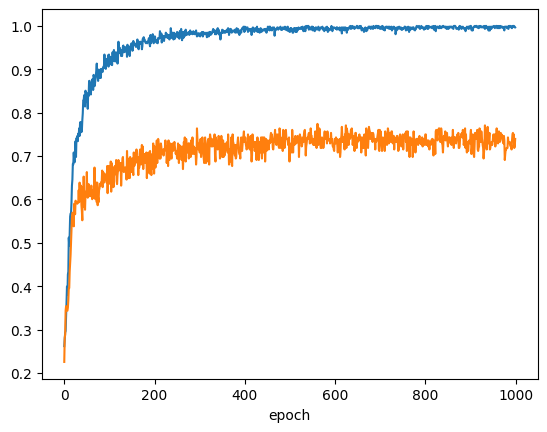

In [44]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

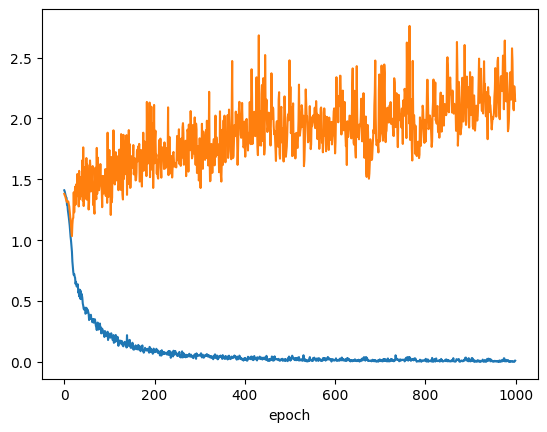

In [45]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [46]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7743
